[link](https://docs.google.com/document/d/1h_1_UxUdzhkjzhMZCcibNOufkU9asa7cdWIZHOFeUMc/edit#heading=h.6qxxdaq5ec9c)

# Desafio Ciência de Dados


### Setup





In [ ]:
# Biblioteca para fine Tunning de modelos
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn -q

In [585]:
# Manipulação do sistema operacional
import os

# Imports para manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# Import bibliotecas estatisticas
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Preprocessamento de dados
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

# Imports para treino de modelos de ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from hpsklearn import HyperoptEstimator,any_preprocessing, gradient_boosting_regressor
from hyperopt import tpe
import pickle

# Metricas de avaliação
from sklearn import metrics

# Setup para configurações no Scikit-learn
from sklearn import set_config



### Configurações

In [6]:
# Defininando a quantidade de casas decimais da visualização dos dados no Pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Definindo estilização do Seaborn para plotagem dos gráficos
sns.set_theme(style="whitegrid", palette="muted")

# Defindo o output do Scikit-Learn como DataFrame Pandas
set_config(transform_output = 'pandas')



### Funções customizadas

Para facilitar a interpretação e explicação das funções utilizadas multiplas vezes, inclui elas abaixo,
- As funções poderiam ser incluidas em um arquivo separado em formato `.py` e importadas no inicio do notebook, decidi por não fazer isso para facilitar a interpretação.

In [7]:
def barplot_custom(df_groupby, col_x, col_y, title, x_label = False, y_label = False, bar_anotate = False, y_lim = False, figsize = (12,8), anotate_float = False):

    ''' 
     Função criada para customizar gráfico de barras.
    '''

    # Plotagem
    plt.figure(figsize= figsize)
    ax = sns.barplot(df_groupby, x=col_x, y = col_y)

    # Definindo título do gráfico
    ax.set_title(title, fontsize=18, weight='bold', color='darkblue')

    # Definição de X_label
    if x_label:
        ax.set_xlabel(x_label, fontsize=14, weight='bold', color='darkblue')
    else:
        ax.set_xlabel("")

    # Definição de Y_label   
    if y_label:
        ax.set_ylabel(y_label, fontsize=14, weight='bold', color='darkblue')
    else: 
        ax.set_ylabel("")

    # Incluindo valores numéricos nas barras
    if bar_anotate:            
        for p in ax.patches:
            if anotate_float:
                ax.annotate(format(p.get_height(), f'.{anotate_float}f'), 
                                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                                  ha = 'center', va = 'center', 
                                  xytext = (0, 9), 
                                  textcoords = 'offset points',
                                  fontsize=12, color='darkblue', weight='bold')
            else:
                ax.annotate(format(p.get_height(), f'.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                  textcoords = 'offset points',
                  fontsize=12, color='darkblue', weight='bold')

            
    # Definindo y_limite        
    if y_lim:
        ax.set_ylim(y_lim)

    # Customizando a fonte dos ticks        
    plt.xticks(fontsize=12, weight='bold', color='darkblue')
    plt.yticks(fontsize=12, weight='bold', color='darkblue')
    plt.show()


## Metodologia CRISP-DM

Este projeto será estruturado seguindo a metodologia CRISP-DM (Cross Industry Standard Process for Data Mining). 

### Fases da Metodologia CRISP-DM
![CRISP DM](Imagens/wi-crisp-en2.jpg)




1. **Entendimento do Negócio**
   - Compreender os objetivos e requisitos do projeto do ponto de vista do negócio.
   - Traduzir essas metas em uma definição do problema que possa ser abordada com dados.

2. **Entendimento dos Dados**
   - Coletar dados iniciais e familiarizar-se com eles.
   - Identificar problemas de qualidade dos dados e começar a encontrar insights iniciais.

3. **Preparação dos Dados**
   - Selecionar e limpar os dados relevantes para a análise.
   - Transformar e formatar os dados conforme necessário para as etapas subsequentes.

4. **Modelagem**
   - Selecionar e aplicar técnicas de modelagem apropriadas.
   - Calibrar parâmetros do modelo para otimizar o desempenho.

5. **Avaliação**
   - Avaliar os modelos para garantir que eles atendam aos objetivos do negócio.
   - Revisar todas as etapas anteriores e verificar se há alguma questão que ainda precisa ser abordada.

6. **Implementação**
   - Implementar o modelo em um ambiente de produção.
   - Documentar o processo e preparar um relatório final com os resultados e conclusões.

### Referência

Para mais informações sobre a metodologia CRISP-DM, consulte a documentação original:

- CRISP-DM 1.0: Step-by-step data mining guide. SPSS Inc. 
[Link para o documento](https://www.kde.cs.uni-kassel.de/wp-content/uploads/lehre/ws2012-13/kdd/files/CRISPWP-0800.pdf)



# 1 - Entendimento do Negócio

Inicialmente podemos definir um objetivo principal que é: **identificar qual tipo de filme a PProductions deve desenvolver a seguir para maximizar o retorno sobre o investimento.**

Para isso podemos classificar algumas metas intermediárias para se aprofundar no entendimento do negócio.
 
- Determinar os gêneros de filmes mais lucrativos.
- Analisar tendências de lançamento bem-sucedidas ao longo dos anos.
- Identificar fatores de sucesso (elenco, diretor, enredo).

Também é importante buscar métricas para quantificar.



# 2. Entendimento dos Dados

###  Dicionário de dados.

A base de dados de treinamento contém 15 colunas. Seus nomes são auto-explicativos, mas, caso haja alguma dúvida, a descrição das colunas é:

| Series_Title | Nome do filme                          |
|--------------|----------------------------------------|
| Released_Year| Ano de lançamento                      |
| Certificate  | Classificação etária                   |
| Runtime      | Tempo de duração                       |
| Genre        | Gênero                                 |
| IMDB_Rating  | Nota do IMDB                           |
| Overview     | Overview do filme                      |
| Meta_score   | Média ponderada de todas as críticas   |
| Director     | Diretor                                |
| Star1        | Ator/atriz #1                          |
| Star2        | Ator/atriz #2                          |
| Star3        | Ator/atriz #3                          |
| Star4        | Ator/atriz #4                          |
| No_of_Votes  | Número de votos                        |
| Gross        | Faturamento                            |



### Carreganto dos Dados

In [8]:
# Carregamento inicial dos dados
data_path = 'Data/desafio_indicium_imdb.csv'
df = pd.read_csv(data_path)\
       .drop('Unnamed: 0', axis = 1)

In [9]:
# Leitura das 5 primeiras linhas dos dados
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175 min,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.00,The early life and career of Vito Corleone in ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,12 Angry Men,1957,U,96 min,"Crime, Drama",9.00,A jury holdout attempts to prevent a miscarria...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


* É possivel notar que na coluna `Genre` possui multiplos generos separados por vírgula.
* Os atores podem se repetir em colunas diferentes.
* A coluna `Runtime` referente ao tempo de filme necessita de correção para a remoção dos caracteres indesejados e transformação para um tipo de dado númerico.
* A coluna `Certificate` pode ser tratada como categorica.

In [10]:
# Exibindo um resumo do conjunto de dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 117.2+ KB


* Nota-se a presença de dados ausentes nas colunas `Certificate`, `Meta_score` e `Gross`.
* As colunas `Released_Year` e `Gross` devem ser alteradas o tipo de dado.

### Dados ausentes

In [11]:
# Exibindo a quantidade de dados nulos por coluna.
df.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Ao analisar a coluna correspondente ao ano de lançamento, é possivel notar que o conjunto de dados possui as informações referente aos filmes lançados do ano 1920 até 2020.


In [12]:
#  Exibindo os anos únicos ordenados de lançamentos dos filmes 
print(df['Released_Year'].sort_values().unique())

#  Exibindo a quantidade anos únicos de lançamentos dos filmes. 
print('\nQuantidade de anos diferentes: {}'.format(len(set(df['Released_Year']))))

['1920' '1921' '1922' '1924' '1925' '1926' '1927' '1928' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960' '1961'
 '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970' '1971'
 '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980' '1981'
 '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991'
 '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001'
 '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' 'PG']

Quantidade de anos diferentes: 100


* Existe também um único valor incorreto preenchido com `PG`

In [13]:
df.query('Released_Year == "PG"')

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.60,NASA must devise a strategy to return Apollo 1...,77.00,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


* Ao consultar e pesquisar os dados, identifiquei que apenas o ano de lançamento do filme Apollo 13 estava incorreto. Embora essa anomalia seja uma sinalização referente à qualidade do conjunto de dados, a correção foi realizada conforme necessário.

In [14]:
# Visualizando os dados próximos ao filme Apollo 13
df.iloc[962:968]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
962,Die Hard: With a Vengeance,1995,A,128 min,"Action, Adventure, Thriller",7.60,John McClane and a Harlem store owner are targ...,58.00,John McTiernan,Bruce Willis,Jeremy Irons,Samuel L. Jackson,Graham Greene,364420,"100,012,499"
963,Dead Man,1995,R,121 min,"Adventure, Drama, Fantasy",7.60,"On the run after murdering a man, accountant W...",62.00,Jim Jarmusch,Johnny Depp,Gary Farmer,Crispin Glover,Lance Henriksen,90442,"1,037,847"
964,The Bridges of Madison County,1995,A,135 min,"Drama, Romance",7.60,Photographer Robert Kincaid wanders into the l...,69.00,Clint Eastwood,Clint Eastwood,Meryl Streep,Annie Corley,Victor Slezak,73172,"71,516,617"
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.60,NASA must devise a strategy to return Apollo 1...,77.00,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"
966,Trois couleurs: Blanc,1994,U,92 min,"Comedy, Drama, Romance",7.60,"After his wife divorces him, a Polish immigran...",88.00,Krzysztof Kieslowski,Zbigniew Zamachowski,Julie Delpy,Janusz Gajos,Jerzy Stuhr,64390,"1,464,625"
967,Falling Down,1993,R,113 min,"Action, Crime, Drama",7.60,An ordinary man frustrated with the various fl...,56.00,Joel Schumacher,Michael Douglas,Robert Duvall,Barbara Hershey,Rachel Ticotin,171640,"40,903,593"


In [15]:
# Correção do ano de lançamento.
df.loc[df['Released_Year'] == 'PG', 'Released_Year'] = 1995

# Transformação para tipo int
df['Released_Year'] = df['Released_Year'].astype(int)

Para auxiliar nas análises criarei uma coluna para segmentar o os filmes por período acumulado de 20 anos e incluindo tags para classificar os filmes por época.

| Anos         | Released_year_tag |
|--------------|-------------------|
| 1920 - 1939  | 1 - Early Cinema  |
| 1940 - 1959  | 2 - Golden Era    |
| 1960 - 1979  | 3 - New Wave      |
| 1980 - 1999  | 4 - Modern Era    |
| 2000 - 2020  | 5 - Contemporary  |

Este tipo de análise é imprescindível, pois o gosto médio pode mudar ao longo do tempo. Além disso, as produtoras têm interesse em rentabilizar, destinando seus recursos de forma mais meticulosa e estudada, visando atrair o máximo de público e arrecadação. Por este motivo, segmentarei minhas análises sempre olhando o total da série histórica e, depois, de forma separada por épocas, para entender a evolução dos gostos e do mercado cinematográfico.

In [16]:
def get_release_year_tag(year) -> str:
    '''
         A função atribui uma tag de ano de lançamento com base no ano fornecido.
    '''
    if 1920 <= year <= 1939:
        return "1 - Early Cinema"
    elif 1940 <= year <= 1959:
        return "2 - Golden Era"
    elif 1960 <= year <= 1979:
        return "3 - New Wave"
    elif 1980 <= year <= 1999:
        return "4 - Modern Era"
    elif 2000 <= year <= 2020:
        return "5 - Contemporary"
    else:
        return "6 - Out of Range"

In [17]:
df['Year_Tag'] = df['Released_Year'].apply(get_release_year_tag)

In [18]:
df.groupby('Year_Tag')[['Series_Title']].count()

,Series_Title
Year_Tag,
1 - Early Cinema,35
2 - Golden Era,91
3 - New Wave,149
4 - Modern Era,239
5 - Contemporary,485


Com isso podemos observar que no conjunto de dados existem mais filmes contemporâneos, pós anos 2000.

Uma hipótese que vale ser analisada é se a época do filme influencia na quantidade de dados ausentes.

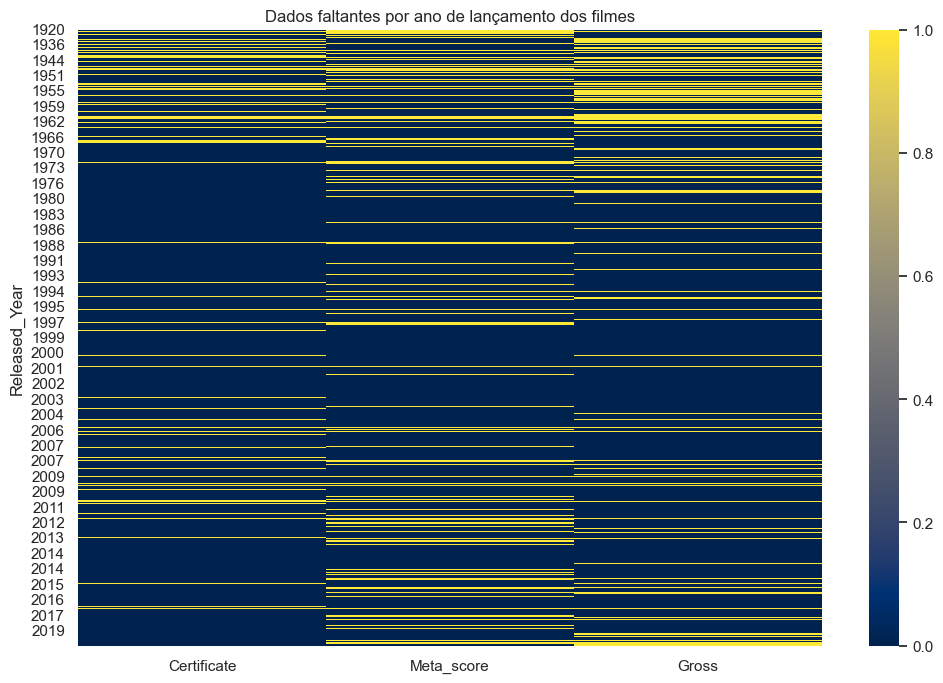

In [19]:
# Gráfico de calor de dados ausentes por ano de lançamento dos filmes
plt.figure(figsize=(12,8))
ax = sns.heatmap(df[['Released_Year','Certificate','Meta_score','Gross']].set_index('Released_Year').sort_values(by = 'Released_Year').isnull(), cmap='cividis')
ax.set_title('Dados faltantes por ano de lançamento dos filmes')
plt.show()

Criei a função `verifica_dados_ausentes_por_ano` para verificar a proporção da quantidade de dados ausentes.

In [20]:
def verifica_dados_ausentes_por_ano(df, ano) -> pd.DataFrame:
    '''
       A função verifica a quantidade e a proporção de dados faltantes até o ano especificado.
    '''

    # Para anos <= ano
    consulta_abaixo = df.query(f'Released_Year <= {ano}')
    tamanho_ano_abaixo = len(consulta_abaixo)
    dados_ausentes_abaixo = consulta_abaixo.isna().sum()
    dados_ausentes_abaixo = dados_ausentes_abaixo[dados_ausentes_abaixo > 0]
    proporcao_a_abaixo = (dados_ausentes_abaixo / tamanho_ano_abaixo) * 100
    
    # Para anos > ano
    consulta_acima = df.query(f'Released_Year > {ano}')
    tamanho_ano_acima = len(consulta_acima)
    dados_ausentes_acima = consulta_acima.isna().sum()
    dados_ausentes_acima = dados_ausentes_acima[dados_ausentes_acima > 0]
    proporcao_a_acima = (dados_ausentes_acima / tamanho_ano_acima) * 100

    # Concatenando os resultados em um DataFrame final
    df_output = pd.concat([dados_ausentes_abaixo, 
                           proporcao_a_abaixo, 
                           dados_ausentes_acima, 
                           proporcao_a_acima], axis=1, 
                           keys=[f'Qtd de Dados Faltantes Ano <= {ano}', 
                                 f'% Dados Faltantes Ano <= {ano}',
                                 f'Qtd de Dados Faltantes Ano > {ano}', 
                                 f'% Dados Faltantes Ano > {ano}']
                           )
    # Retornando o DataFrame estilizando com um mapa de calor por coluna. 
    return df_output.style.background_gradient(cmap="coolwarm")

- Após os anos 80 dimínui consideravelmente a proporção de dados ausentes no conjunto de dados.

In [21]:
# Exibindo a quantiadade e proporção dos dados ausentes por ano menor e maior que 1980.
verifica_dados_ausentes_por_ano(df, 1980)

,Qtd de Dados Faltantes Ano <= 1980,% Dados Faltantes Ano <= 1980,Qtd de Dados Faltantes Ano > 1980,% Dados Faltantes Ano > 1980
Certificate,57,20.141343,44,6.145251
Meta_score,67,23.674912,90,12.569832
Gross,97,34.275618,72,10.055866


**O decorador `interact` do pacote `ipywidgets` pode não exibir os seus resultados no GitHub, sendo necessária a execução do notebook localmente.**

* Com o interador é possivel visualizar de forma mais dinâmica os dados ausentes por ano



In [22]:
# Utilizando o decorardor interact do Ipywidgets para visualizar de forma interativa os dados ausentes.
@interact(ano = set(df.Released_Year))
def analisa_ano(ano):
    return verifica_dados_ausentes_por_ano(df,ano)

interactive(children=(Dropdown(description='ano', options=(1920, 1921, 1922, 1924, 1925, 1926, 1927, 1928, 193…

### Dados duplicados

Não identifiquei linhas duplicadas no conjunto de dados.

In [23]:
# Verificando se existem linhas em todos os dados são duplicados
df[df.duplicated()]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag


No entanto, verifiquei também a presença de filmes com nomes duplicados e se existem descrições repetidas.

In [24]:
# Verificando se existem títulos de filmes duplicados
df[df.duplicated(subset=['Series_Title'])]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag
135,Drishyam,2015,UA,163 min,"Crime, Drama, Mystery",8.20,Desperate measures are taken by a man who trie...,NaN,Nishikant Kamat,Ajay Devgn,Shriya Saran,Tabu,Rajat Kapoor,70367,"739,478",5 - Contemporary


Ao pesquisar sobre estes títulos identifiquei que são filmes distintos.

In [25]:
# Filmes com Títulos íguais.
df[df['Series_Title'] == 'Drishyam']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag
86,Drishyam,2013,U,160 min,"Crime, Drama, Thriller",8.30,A man goes to extreme lengths to save his fami...,NaN,Jeethu Joseph,Mohanlal,Meena,Asha Sharath,Ansiba,30722,NaN,5 - Contemporary
135,Drishyam,2015,UA,163 min,"Crime, Drama, Mystery",8.20,Desperate measures are taken by a man who trie...,NaN,Nishikant Kamat,Ajay Devgn,Shriya Saran,Tabu,Rajat Kapoor,70367,"739,478",5 - Contemporary


Não há descrições duplicadas.

In [26]:
# Verificando se existem descrições de filmes duplicadas
df[df.duplicated(subset=['Overview'])]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag


Analisarei as informações presentes na coluna `Certificate`.

[Siglas de Certificação](https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpart_nav_27#)

| Classificação             | Descrição                                                                                      |
|---------------------------|------------------------------------------------------------------------------------------------|
| U (Universal)             | Adequado para todos os públicos.                                                               |
| A (Adult)                 | Adequado somente para adultos.                                                                 |
| UA (Universal/Adult)      | Adequado para públicos acima de 12 anos, acompanhadas de um adulto.                            |
| R (Restricted)            | Restrito, menores de 17 anos precisam estar acompanhados de um adulto.                         |
| CD                        | Classificação não identificada ou não especificada.                                            |
| PG-13 (Parents Strongly Cautioned) | Inadequados para menores de 13 anos.                                                  |
| PG (Parental Guidance)    | Supervisão dos pais sugerida, não adequadas para crianças.                                     |
| Passed                    | Classificação antiga que indica que o filme foi aprovado em sua época.                         |
| G (General Audiences)     | Adequado para todos os públicos.                                                               |
| Approved                  | Classificação antiga que indica que o filme foi aprovado em sua época.                         |
| TV-PG (Parental Guidance Suggested) | Supervisão dos pais sugerida para programas de televisão.                            |
| GP                        | Supervisão dos pais sugerida                                                                   |
| TV-14                     | Adequado para maiores de 14 anos, programas de televisão.                                      |
| 16                        | Adequado para maiores de 16 anos.                                                              |
| TV-MA (Mature Audience)   | Adequado apenas para adultos, programas de televisão.                                          |
| Unrated                   | Filme não classificado.                                                                        |
| U/A                       | Adequado para públicos acima de 12 anos, acompanhadas de um adulto.                            |


A classificação mais frequente como podemos ver é U (Universal).

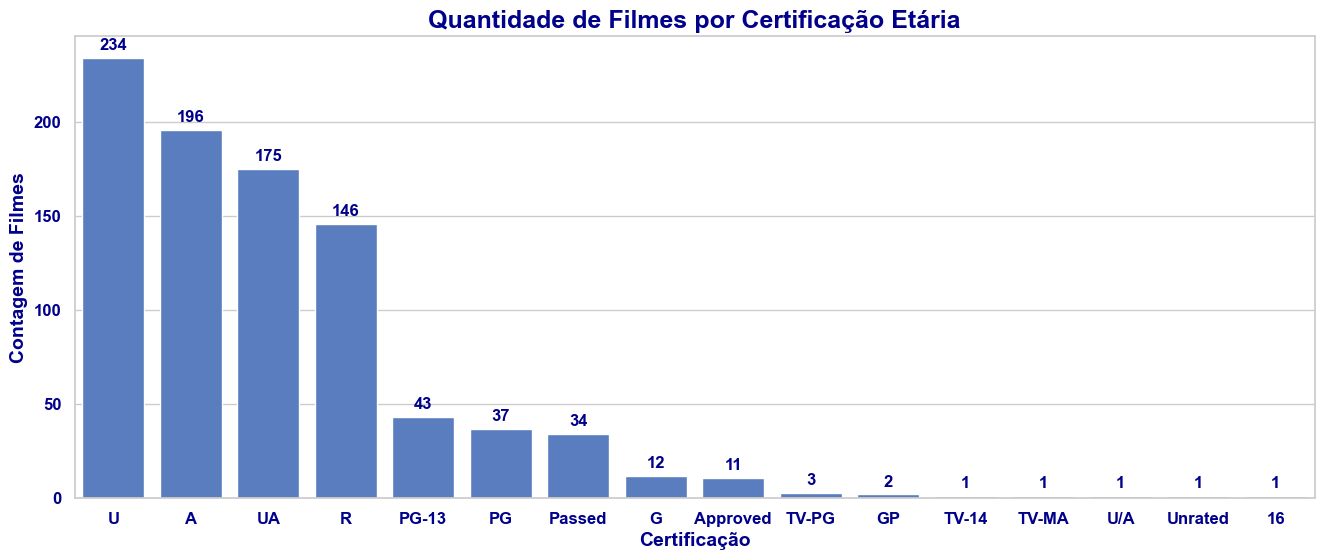

In [27]:
# Criando um DataFrame provisorio com dados agrupados por Certificados e contabilizando a quantidade de filmes
df_groupby = df_groupby = df.groupby("Certificate", dropna=False).agg(quantidade_filmes = ('Series_Title', 'count'))\
                            .sort_values('quantidade_filmes',ascending=False) 

# Plotagem dos dados agrupados de forma ordenada
barplot_custom(df_groupby,
               figsize=(16,6),
               col_x= 'Certificate',
               col_y = 'quantidade_filmes',
               title="Quantidade de Filmes por Certificação Etária",
               y_label='Contagem de Filmes',
               x_label = "Certificação",
               bar_anotate = True)

Os dados referente ao faturamento e o tempo de filme são necessários um tratamento prévio para podermos analisá-los, removi os caracteres indesejados e transformei os dados para tipos adequados, convertendo de `str` para `int` e `float`.

In [28]:
# Tratamento necessário no conjunto de dados.
df['Gross'] = df['Gross'].str.replace(',','').astype(float)
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)

In [29]:
# Agrupando por Certificação e época
df.groupby(['Certificate','Year_Tag'], dropna=False).agg(quantidade_filmes = ('Year_Tag','count'), 
                                                         faturamento_total = ('Gross','sum'),
                                                         faturamento_medio = ('Gross','mean'))\
  .sort_values('faturamento_total',ascending=False)\
  .head(10)

,,quantidade_filmes,soma_gross,gross_medio
Certificate,Year_Tag,,,
UA,5 - Contemporary,135,17912951128.00,141046859.28
U,5 - Contemporary,90,9421065974.00,114891048.46
A,5 - Contemporary,83,6133574141.00,78635565.91
U,4 - Modern Era,84,6095888574.00,80209060.18
A,4 - Modern Era,55,3225232812.00,62023707.92
UA,4 - Modern Era,34,3087481705.00,99596184.03
R,5 - Contemporary,91,2373814256.00,28259693.52
A,3 - New Wave,49,2066522599.00,48058665.09
U,3 - New Wave,40,1460567168.00,50364385.10


* Nota-se que os filmes com classificação `UA` (Universal/Adult) e contemporaneos possuem uma arrecadação média maior que as demais classificações e somam o maior faturamento.
* Outro melhoria possivel seria simplificar as certificações e adotar um padrão único, visto que existem certificações que foram somente renomeadas.

A função interativa abaixo exibe de forma interativa a quantidade de filmes, suas respectivas épocas, faturamento total e faturamento médio agrupados pela certificação do filme.

In [30]:
@interact(cetificate = set(df.Certificate))
def group_certificate(cetificate):
  output = df.groupby(['Certificate','Year_Tag'],dropna=False).agg(quantidade_filmes = ('Year_Tag','count'), 
                                                                   faturamento_total = ('Gross','sum'),
                                                                   faturamento_medio = ('Gross','mean'))\
             .reset_index()\
             .query(f'Certificate == "{cetificate}"')
  
  return output.reset_index(drop=True)

interactive(children=(Dropdown(description='cetificate', options=('Approved', nan, 'R', 'Passed', 'PG-13', 'U/…

### Tempo de duração dos filmes

Analisando o tempo de duração dos filmes podemos notar que os filmes ficaram mais longos média estabilizando-se entre 123 e 126 minutos de duração após 1960.

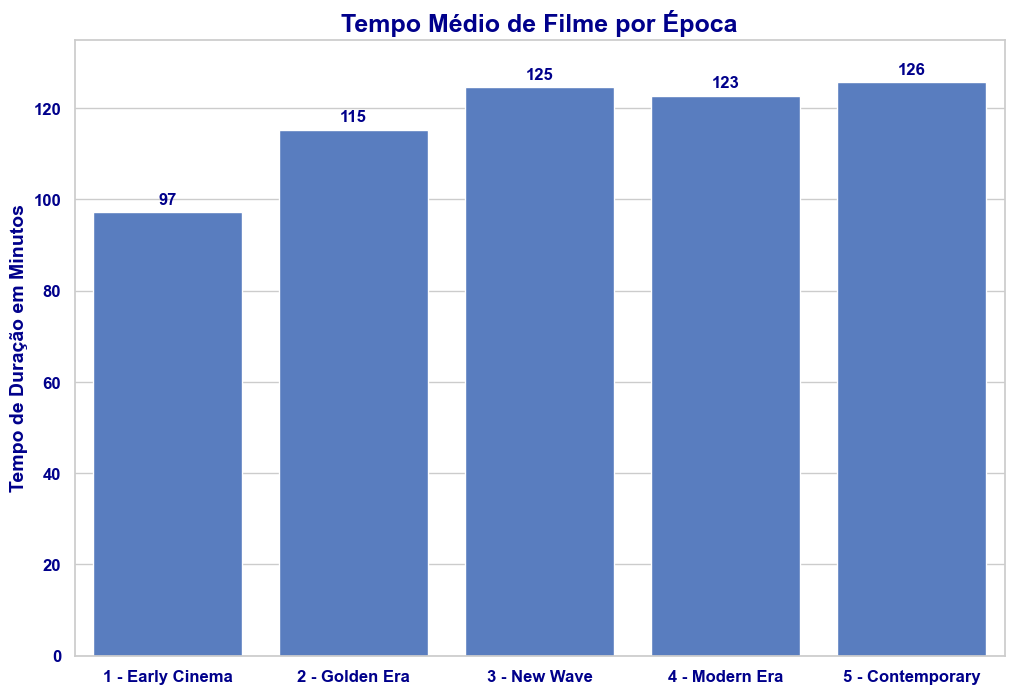

In [31]:
df_groupby = df.groupby('Year_Tag').agg(tempo_medio_de_filme = ("Runtime", "mean"))


barplot_custom(df_groupby,
               col_x= 'Year_Tag',
               col_y = 'tempo_medio_de_filme',
               title="Tempo Médio de Filme por Época",
               y_label='Tempo de Duração em Minutos',
               bar_anotate = True,
               y_lim=[0,135])

### Generos

Para poder analisar os gêneros dos filmes, efetuei a separação dos generos presentes em cada filme gerando um novo DataFrame.

In [94]:
# Separandos os generos dos filmes
generos = df.assign(Genre=df['Genre'].str.split(', '))\
            .explode('Genre')

# Visualizando o DataFrame com os gêneros separados
generos.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag
0,The Godfather,1972,A,175,Crime,9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,3 - New Wave
0,The Godfather,1972,A,175,Drama,9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.00,3 - New Wave
1,The Dark Knight,2008,UA,152,Action,9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,5 - Contemporary
1,The Dark Knight,2008,UA,152,Crime,9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,5 - Contemporary
1,The Dark Knight,2008,UA,152,Drama,9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,5 - Contemporary


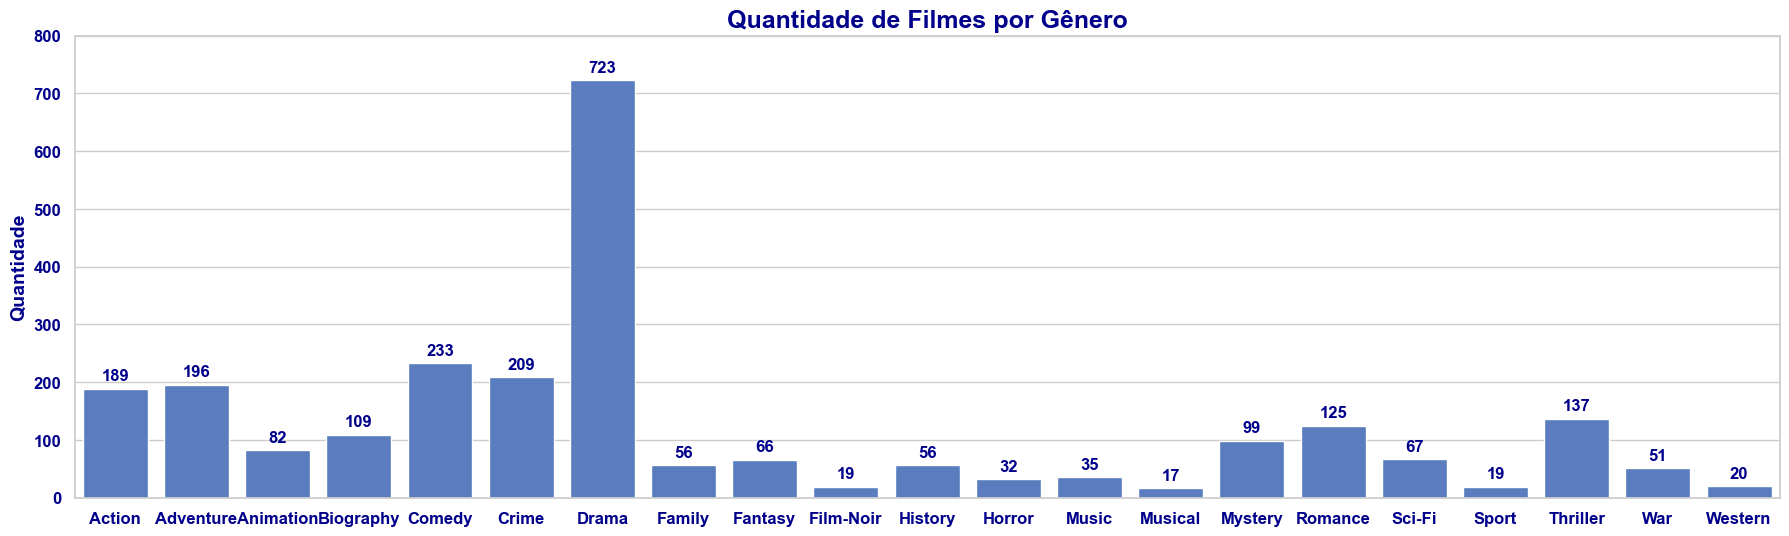

In [76]:
# Contabilizando a quantidade filmes agrupadas por gênero.
df_groupby = generos.groupby("Genre").agg(quantidade_filmes = ('Series_Title', 'count'))

barplot_custom(df_groupby,
               figsize=(22,6),
               col_x= 'Genre',
               col_y = 'quantidade_filmes',
               title="Quantidade de Filmes por Gênero",
               y_label='Quantidade',
               bar_anotate = True,
               y_lim=[0,800])

Gerei um gráfico interativo em que é possivel visualizar de forma segmentada por época a quantidade de filmes por gênero
* É possivel notar que o gênero drama é predominante independente da época.
* Também nota-se que o gênero comédia entrou em declínio após os anos 2000.

In [80]:
@interact(year_tag = set(generos.Year_Tag))
def plot_bar_plot_custom_interativo(year_tag):
    # Contando a quantidade de filme agrupando por genero e filtrando os dados por época
    df_groupby = generos.query(f'Year_Tag == "{year_tag}"')\
                        .groupby("Genre").agg(quantidade_filmes = ('Series_Title', 'count'))\
                        .sort_values("quantidade_filmes",ascending = False)
    
    # Plotagem do gráfico de barras quantidade de filmes por gênero na época de forma interativa
    barplot_custom(df_groupby,
                   figsize=(22,6),
                   col_x= 'Genre',
                   col_y = 'quantidade_filmes',
                   title=f"Quantidade de Filmes por Gênero na Época {year_tag}",
                   y_label='Quantidade',
                   bar_anotate = True)

interactive(children=(Dropdown(description='year_tag', options=('4 - Modern Era', '2 - Golden Era', '3 - New W…

O gênero aventura demonstra-se o mais lucrativo em toda a séria histórica.

In [35]:
# Verificando o top 10 faturamento total por gênero.
df_groupby = generos.groupby('Genre').agg(soma_faturamento = ('Gross', 'sum'))\
                    .sort_values('soma_faturamento',ascending = False)\
                    .head(10)

df_groupby

,soma_faturamento
Genre,
Adventure,28174317369.00
Drama,27469281160.00
Action,22033328131.00
Comedy,12247931579.00
Sci-Fi,9029610220.00
Animation,8573824407.00
Crime,6956303927.00
Thriller,6454428931.00
Fantasy,6082543147.00


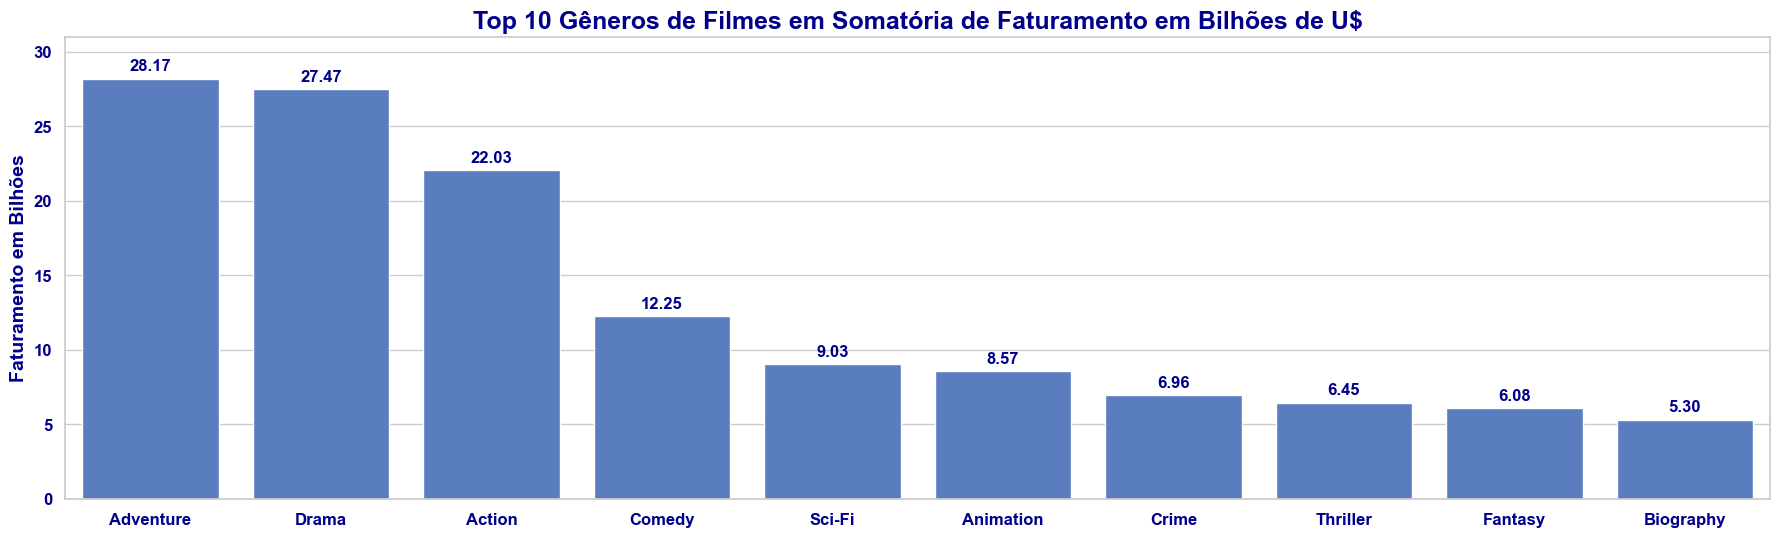

In [36]:
# Convertendo a soma do faturamento em bilhões para facilitar a plotagem do gráfico.
df_groupby['soma_faturamento'] = df_groupby['soma_faturamento'] / 10**9

# Plotagem dos dados top 10 gêneros de filmes em somatória de faturamento em bilhões de U$
barplot_custom(df_groupby,
               figsize=(22,6),
               col_x= 'Genre',
               col_y = 'soma_faturamento',
               title="Top 10 Gêneros de Filmes em Somatória de Faturamento em Bilhões de U$",
               y_label='Faturamento em Bilhões',
               y_lim=[0,31],
               bar_anotate=True,
               anotate_float=2)

- Com o gráfico interativo podemos notar, que o faturamento aumentou em alguns gêneros em mais de 1000%
- O faturamento gênero drama multiplicou em mais de 3x em comparação aos filmes dos anos 80 e 2000.

In [37]:
@interact(year_tag = set(generos.Year_Tag))

# Gráfico interativo com a plotagem dos dados top 10 gêneros de filmes em somatória de faturamento em bilhões de U$ por época
def plot_bar_plot_custom_interativo(year_tag):
    df_groupby = generos.query(f'Year_Tag == "{year_tag}"')\
                        .groupby('Genre').agg(soma_faturamento = ('Gross', 'sum'))\
                        .sort_values('soma_faturamento',ascending = False)\
                        .head(10)
    
    # Alterando o a soma do faturamento para bilhões para melhorar a plotagem
    df_groupby['soma_faturamento'] = df_groupby['soma_faturamento'] / 10**9

    barplot_custom(df_groupby,
                   figsize=(22,6),
                   col_x= 'Genre',
                   col_y = 'soma_faturamento',
                   title=f"Top 10 Gêneros de Filmes em Somatória de Faturamento em Bilhões de U$ por Época: {year_tag}",
                   y_label='Faturamento em Bilhões',
                   bar_anotate=True,
                   anotate_float=2)

interactive(children=(Dropdown(description='year_tag', options=('4 - Modern Era', '2 - Golden Era', '3 - New W…

Analisando o gráfico interativo de faturamento médio de gênero por época, constatei que o faturamento médio contemporâneo traz o gênero Sci-fi para o Top 1. Isso indica que existem filmes de aventura que são outliers, destoando-se, e possivelmente o gênero Sci-fi tem bilheterias mais consistentes.

In [39]:
@interact(year_tag = set(generos.Year_Tag))
def plot_bar_plot_custom_interativo(year_tag):
    df_groupby = generos.query(f'Year_Tag == "{year_tag}"')\
                        .groupby('Genre').agg(faturamento_medio = ('Gross', 'mean'))\
                        .sort_values('faturamento_medio',ascending = False)\
                        .head(10)
    

    # Alterando o a soma do faturamento para milhões para melhorar a plotagem
    df_groupby['faturamento_medio'] = df_groupby['faturamento_medio'] / 10**6

    barplot_custom(df_groupby,
                   figsize=(22,6),
                   col_x= 'Genre',
                   col_y = 'faturamento_medio',
                   title  = f"Top 10 Gêneros de Filmes em Faturamento Médio em Milhões de U$ por Época: {year_tag}",
                   y_label='Faturamento em Milhões',
                   bar_anotate=True,
                   anotate_float=False)

interactive(children=(Dropdown(description='year_tag', options=('4 - Modern Era', '2 - Golden Era', '3 - New W…

- Curiosamente, o gênero Western com somente 2 filmes teve ótimas bilheterias nos filmes contemporâneos, sendo o 4 gênero com mélhor média de faturamento.

In [40]:
# Filtrando
generos.query('Year_Tag == "5 - Contemporary" & Genre == "Western"')

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag
61,Django Unchained,2012,A,165,Western,8.40,"With the help of a German bounty hunter, a fre...",81.00,Quentin Tarantino,Jamie Foxx,Christoph Waltz,Leonardo DiCaprio,Kerry Washington,1357682,162805434.00,5 - Contemporary
903,True Grit,2010,PG-13,110,Western,7.60,A stubborn teenager enlists the help of a toug...,80.00,Ethan Coen,Joel Coen,Jeff Bridges,Matt Damon,Hailee Steinfeld,311822,171243005.00,5 - Contemporary


- Considerando-se a quantidade de avaliações de filmes contemporâneos, o gênero Drama segue disparado como top 1 e o filmes de gênero Musical são os que menos recebem avaliações.

In [41]:
generos.query('Year_Tag == "5 - Contemporary"')\
       .groupby("Genre").agg(total_votos = ("No_of_Votes", 'sum'))\
       .sort_values("total_votos", ascending=False)

,total_votos
Genre,
Drama,100713149
Adventure,60920654
Action,55675378
Comedy,32234492
Crime,29987181
Thriller,24371543
Sci-Fi,23527754
Biography,19221604
Mystery,17542493


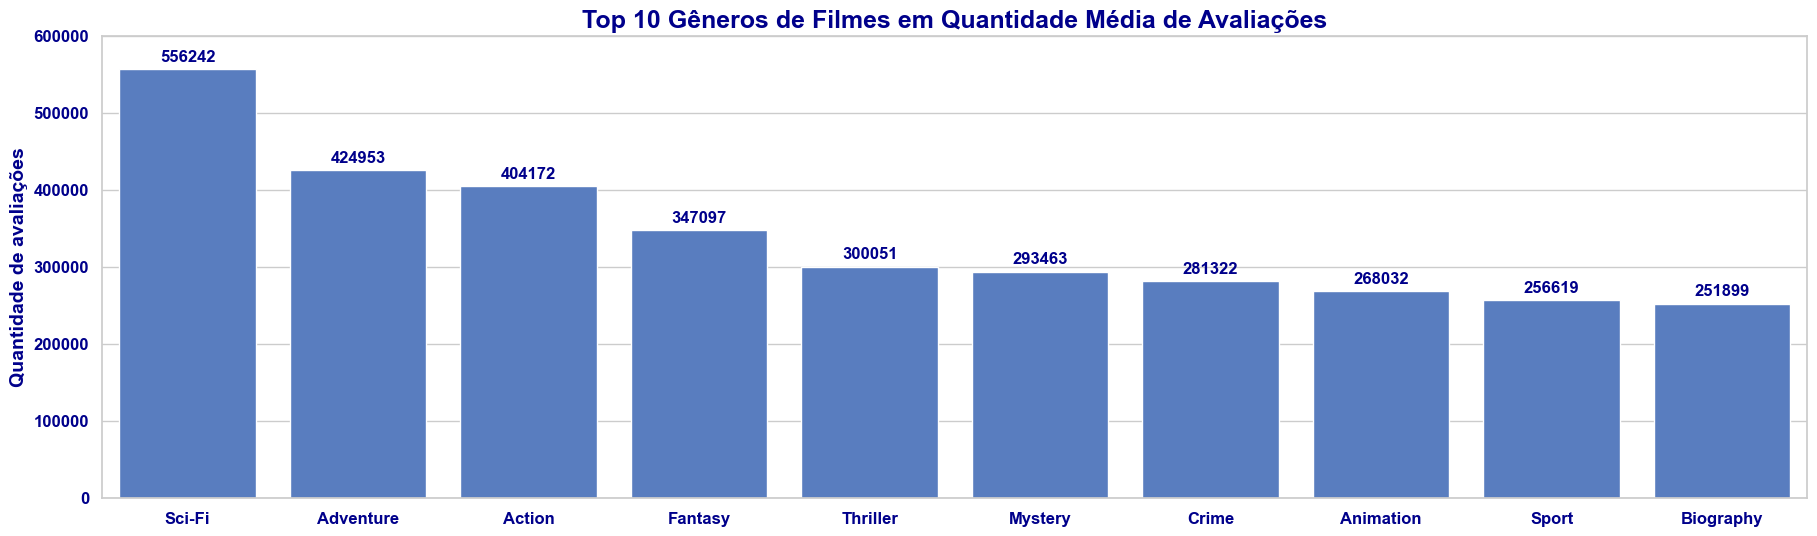

In [42]:
# Agrupando a quantidade de votos média por gênero.
df_groupby = generos.groupby('Genre').agg(qtd_votos_medio = ('No_of_Votes', 'mean'))\
                    .sort_values('qtd_votos_medio', ascending = False)\
                    .head(10)

# Plotagem dos dados agrupados top 10 gêneros de filmes em quantidade média de avaliações
barplot_custom(df_groupby,
               figsize=(22,6),
               col_x= 'Genre',
               col_y = 'qtd_votos_medio',
               title="Top 10 Gêneros de Filmes em Quantidade Média de Avaliações",
               y_label='Quantidade de avaliações',
               bar_anotate=True,
               y_lim=[0,600000])

In [43]:
@interact(year_tag = set(generos.Year_Tag))
def plot_bar_plot_custom_interativo(year_tag):
    df_groupby = generos.query(f'Year_Tag == "{year_tag}"')\
                        .groupby('Genre').agg(qtd_votos_medio = ('No_of_Votes', 'mean'))\
                        .sort_values('qtd_votos_medio', ascending = False)\
                        .head(10)
    max = df_groupby['qtd_votos_medio'].max() * 1.1

    barplot_custom(df_groupby,
                   figsize=(22,6),
                   col_x= 'Genre',
                   col_y = 'qtd_votos_medio',
                   title=f"Top 10 Gêneros de Filmes em Quantidade Média de Avaliações por Época: {year_tag}",
                   y_label='Quantidade de avaliações',
                   bar_anotate=True,
                   y_lim=[0,max])

interactive(children=(Dropdown(description='year_tag', options=('4 - Modern Era', '2 - Golden Era', '3 - New W…

Como existem filmes com orçamentos e faturamentos estratosféricos, irei realizar a análise removendo os valores outliers, para verificar se o comportamento permanece o mesmo.

In [90]:
def remove_outiliers(data):
    '''
        Função para identificar os indices e filtrar valores outliers
    '''
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    mask = (data >= (Q1 - 1.5 * IQR)) & (data <= (Q3 + 1.5 * IQR))
    
    return data[mask].index



In [88]:
faturamento_idx_sem_outliers = remove_outiliers(df['Gross'])

In [93]:
# Separandos os generos dos filmes e removendo filmes com faturamento outliers
generos_outliers = df.iloc[faturamento_idx_sem_outliers]\
                     .assign(Genre=df['Genre'].str.split(', '))\
                     .explode('Genre')

**Estou utilizando a estilização do Pandas incluindo cores para os valores máximos e mínimos, a visualização destes elementos podem não ser disponíveis diretamente no GitHub**

In [102]:
# Verificando a rentabilidade e avaliações sem outliers por gênero
df_groupby = generos_outliers.groupby('Genre').agg(soma_faturamento = ('Gross', 'sum'),
                                                   faturamento_medio = ('Gross', 'mean'),
                                                   quantidade_avaliacoes = ('No_of_Votes', 'sum'),\
                                                   quantidade_avaliacoes_media = ('No_of_Votes', 'mean'))\
                             .style.highlight_max(color='green')\
                                   .highlight_min(color = 'red')

df_groupby

,soma_faturamento,faturamento_medio,quantidade_avaliacoes,quantidade_avaliacoes_media
Genre,,,,
Action,5894588697.000000,53104402.675676,35140508,316581.153153
Adventure,5896540576.000000,56697505.538462,30833089,296472.009615
Animation,1781703688.000000,40493265.636364,7530323,171143.704545
Biography,4832190279.000000,51406279.563830,25516349,271450.521277
Comedy,5360952957.000000,31910434.267857,35577857,211772.958333
Crime,5834480187.000000,34729048.732143,52558984,312851.095238
Drama,20133287679.000000,35075414.074913,141999617,247386.092334
Family,1632504121.000000,42960634.763158,6178722,162597.947368
Fantasy,1541368984.000000,36699261.523810,11230174,267385.095238


In [120]:
@interact(metricas = list(df_groupby.columns), tag_epoca = set(generos_outliers.Year_Tag))

# Verificando as métricas médias e total de faturamento e avaliações por época de forma interativa
def groupby_interativo(metricas, tag_epoca):
      if metricas == "soma_faturamento":
          df_groupby =  generos_outliers.query(f"Year_Tag == '{tag_epoca}'").groupby('Genre').agg(soma_faturamento = ('Gross', 'sum'))
      elif metricas == "faturamento_medio":
           df_groupby =  generos_outliers.query(f"Year_Tag == '{tag_epoca}'").groupby('Genre').agg(faturamento_medio = ('Gross', 'mean'))
      elif metricas == "quantidade_avaliacoes":
           df_groupby =  generos_outliers.query(f"Year_Tag == '{tag_epoca}'").groupby('Genre').agg(quantidade_avaliacoes = ('No_of_Votes', 'sum'))
      elif metricas == "quantidade_avaliacoes_media":
           df_groupby =  generos_outliers.query(f"Year_Tag == '{tag_epoca}'").groupby('Genre').agg(quantidade_avaliacoes_media = ('No_of_Votes', 'mean'))
           
      return df_groupby.style.highlight_max(color='green').highlight_min(color = 'red')

interactive(children=(Dropdown(description='metricas', options=('soma_faturamento', 'faturamento_medio', 'quan…

### Conclusão sobre os Gêneros

* O gênero drama se destaca em faturamento e quantidade de avaliações, mesmo após desconsiderarmos valores "outliers" de faturamento, portanto é o gênero mais lucrativo da atualidade.

* O gênero drama está bem representado independentemente da época; os filmes deste gênero podem ser mais longevos.
* Os filmes gênero Sci-fi tem uma quantidade votos maior do que os demais gêneros de filmes o que pode sinalizar que há um interesse significativo do público por temas futuristas, tecnológicos e especulativos que esses filmes exploram.

### Direção

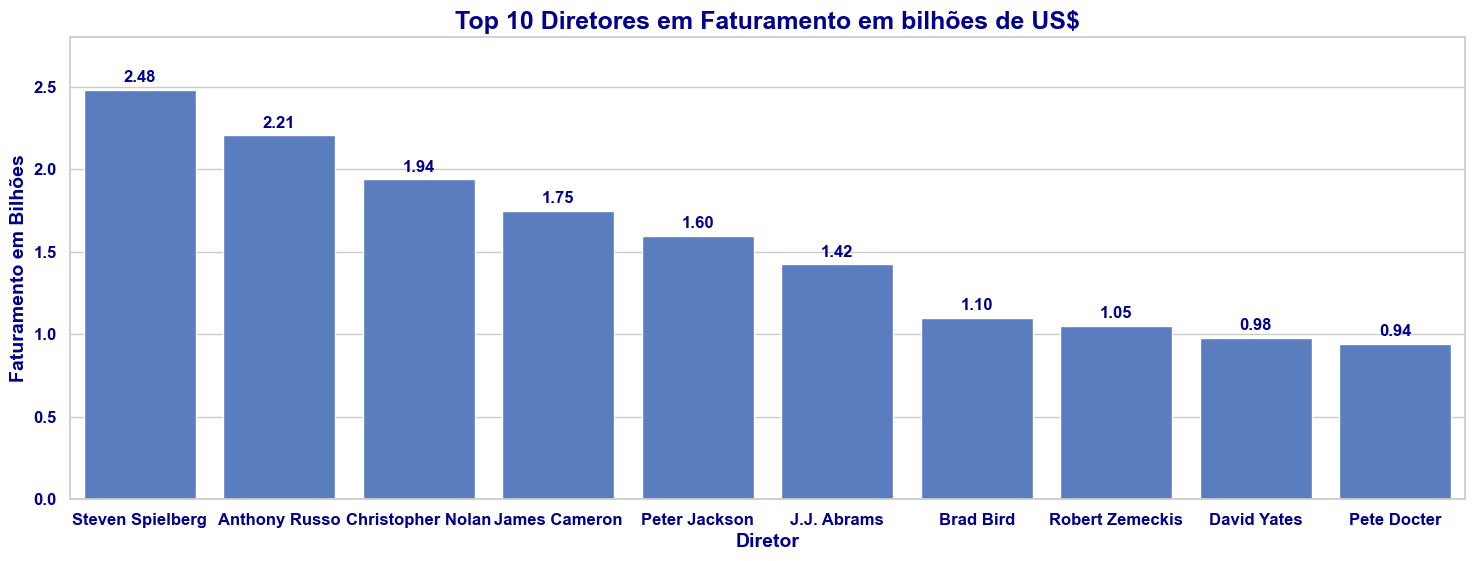

In [44]:
# Agrupando o faturamento total dos filmes por diretor.
df_groupby = df.groupby("Director").agg(faturamento_total = ("Gross","sum"))\
               .sort_values("faturamento_total",ascending=False)\
               .head(10)

df_groupby["faturamento_total"] = df_groupby["faturamento_total"] / 10**9

barplot_custom(df_groupby,
               figsize=(18,6),
               col_x= 'Director',
               col_y = 'faturamento_total',
               title="Top 10 Diretores em Faturamento em bilhões de US$",
               y_label='Faturamento em Bilhões',
               x_label = 'Diretor',
               bar_anotate=True,
               anotate_float=2,
               y_lim=[0, 2.8])

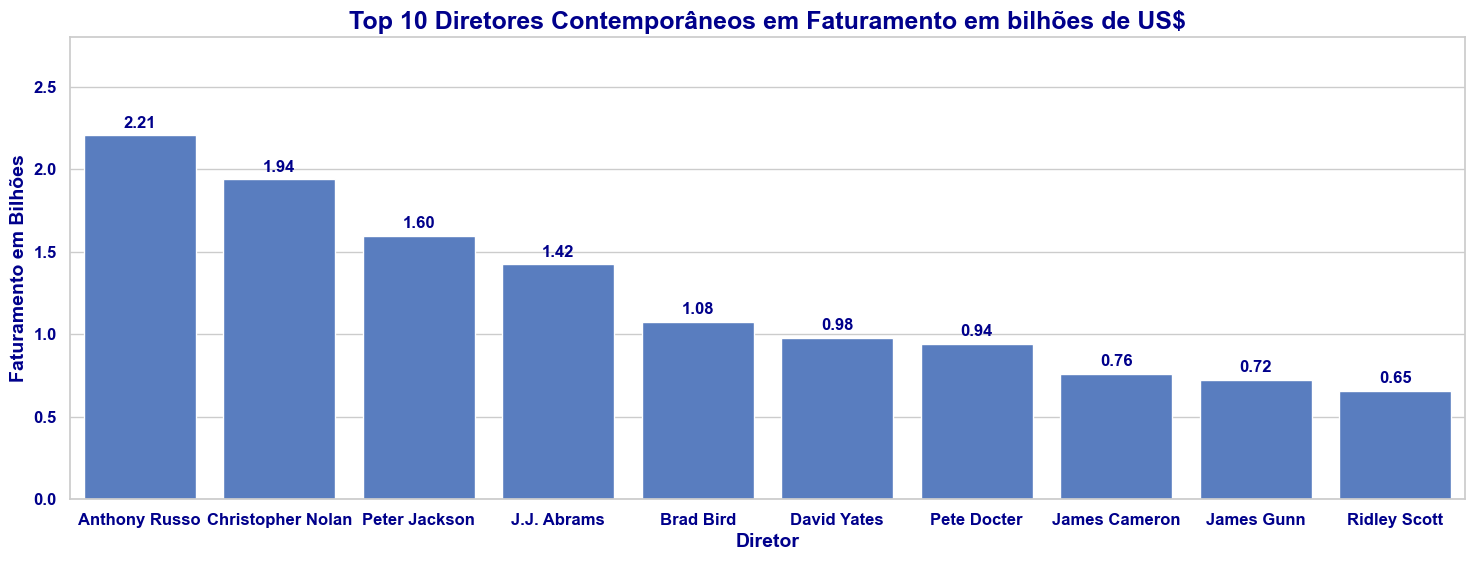

In [45]:
# Agrupando o faturamento total por diretor dos filmes contemporâneos.
df_groupby = df.query('Year_Tag == "5 - Contemporary"')\
               .groupby("Director").agg(faturamento_total = ("Gross","sum"))\
               .sort_values("faturamento_total",ascending=False)\
               .head(10)

df_groupby["faturamento_total"] = df_groupby["faturamento_total"] / 10**9

barplot_custom(df_groupby,
               figsize=(18,6),
               col_x= 'Director',
               col_y = 'faturamento_total',
               title= "Top 10 Diretores Contemporâneos em Faturamento em bilhões de US$",
               y_label='Faturamento em Bilhões',
               x_label = 'Diretor',
               bar_anotate=True,
               anotate_float=2,
               y_lim=[0, 2.8])

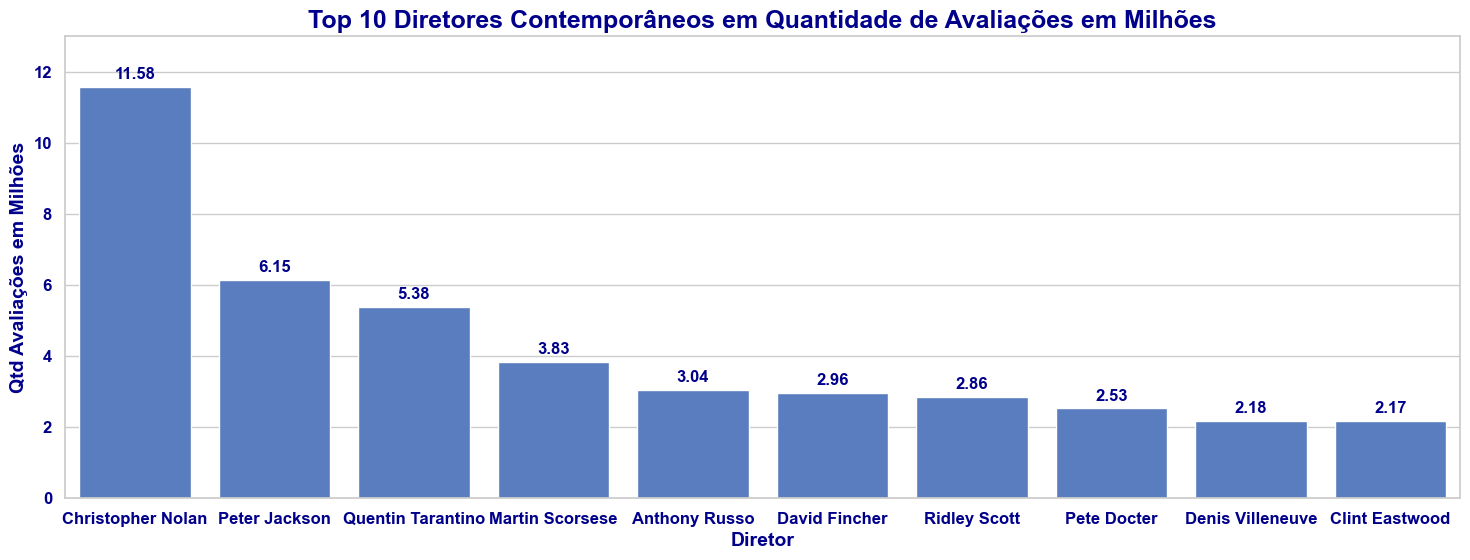

In [48]:
# Agrupando a quantidade total de avaliações por diretor dos filmes contemporâneos.

df_groupby = df.query('Year_Tag == "5 - Contemporary"')\
               .groupby("Director").agg(qtd_avaliacoes = ("No_of_Votes","sum"))\
               .sort_values("qtd_avaliacoes", ascending=False)\
               .head(10)

df_groupby["qtd_avaliacoes"] = df_groupby["qtd_avaliacoes"] / 10**6

barplot_custom(df_groupby,
               figsize=(18,6),
               col_x= 'Director',
               col_y = 'qtd_avaliacoes',
               title= "Top 10 Diretores Contemporâneos em Quantidade de Avaliações em Milhões",
               y_label='Qtd Avaliações em Milhões',
               x_label = 'Diretor',
               bar_anotate=True,
               anotate_float=2,
               y_lim=[0,13])

- O diretor de maior destaque é o Christopher Nolan, que contem a maior quantidade de avaliações e o segundo maior faturamento.

### Elenco

Irei únir em uma só coluna em um novo DataFrame os atores dos filmes, desta forma facilitará em analisar os atores mais rentaveis.

In [49]:
# Selecionando em uma lista as colunas do elenco
actor_columns = ['Star1', 'Star2', 'Star3', 'Star4']

# Selcionando em uma lista as demais colunas
columns_melt = list(df.drop(actor_columns,axis = 1).columns)

# Gerando novo dtaframe "concatenando" por ator.
actors_df = df.melt(columns_melt, actor_columns, var_name = 'Star', value_name = 'Actor')
actors_df.head()


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Year_Tag,Star,Actor
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,1620367,134966411.00,3 - New Wave,Star1,Marlon Brando
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,2303232,534858444.00,5 - Contemporary,Star1,Christian Bale
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.00,The early life and career of Vito Corleone in ...,90.00,Francis Ford Coppola,1129952,57300000.00,3 - New Wave,Star1,Al Pacino
3,12 Angry Men,1957,U,96,"Crime, Drama",9.00,A jury holdout attempts to prevent a miscarria...,96.00,Sidney Lumet,689845,4360000.00,2 - Golden Era,Star1,Henry Fonda
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,1642758,377845905.00,5 - Contemporary,Star1,Elijah Wood


In [121]:
# Filtrando um filme para exibir o resultado
actors_df.loc[actors_df['Series_Title'] == 'The Godfather']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Year_Tag,Star,Actor
0,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,1620367,134966411.00,3 - New Wave,Star1,Marlon Brando
999,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,1620367,134966411.00,3 - New Wave,Star2,Al Pacino
1998,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,1620367,134966411.00,3 - New Wave,Star3,James Caan
2997,The Godfather,1972,A,175,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,1620367,134966411.00,3 - New Wave,Star4,Diane Keaton


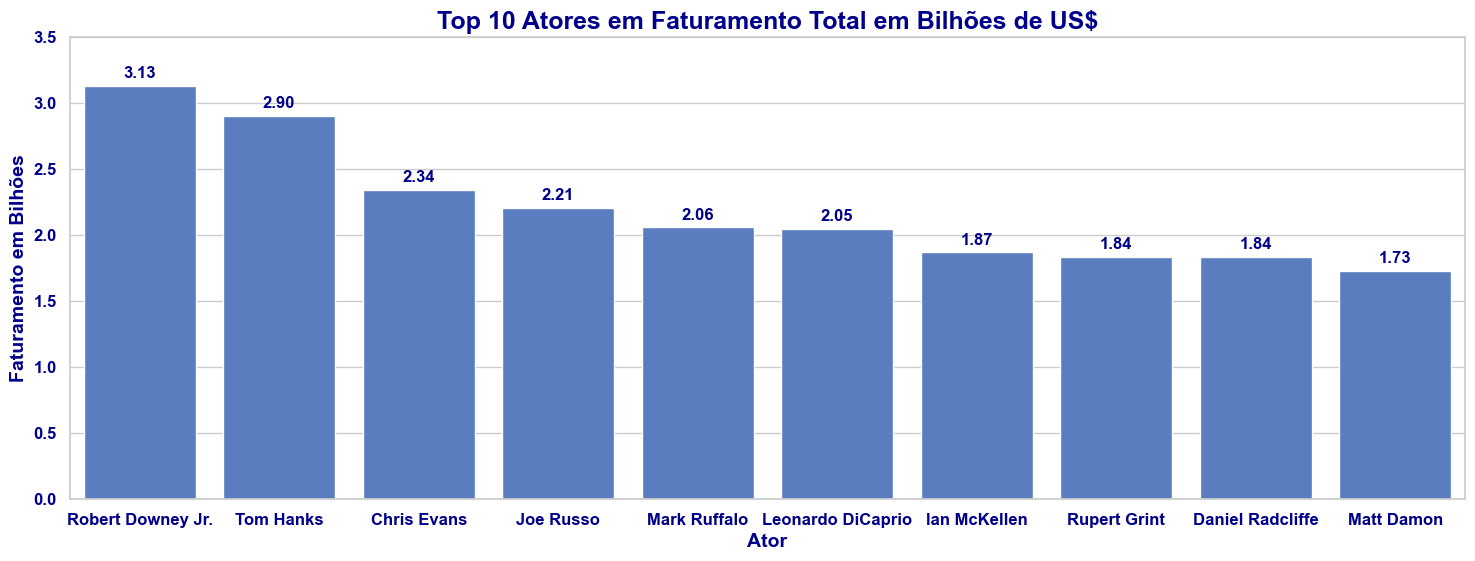

In [51]:
# Obtendo o faturamento total de filmes por ator 
df_groupby = actors_df.groupby("Actor").agg(faturamento_soma = ("Gross", "sum"))\
                      .sort_values("faturamento_soma",ascending=False)\
                      .head(10)

# Convertendo o resultado para bilhões para facilitar a plotagem.
df_groupby["faturamento_soma"] = df_groupby["faturamento_soma"] / 10**9

barplot_custom(df_groupby,
               figsize=(18,6),
               col_x= 'Actor',
               col_y = 'faturamento_soma',
               title= "Top 10 Atores em Faturamento Total em Bilhões de US$",
               y_label='Faturamento em Bilhões',
               x_label = 'Ator',
               bar_anotate=True,
               anotate_float=2,
               y_lim=[0,3.5])

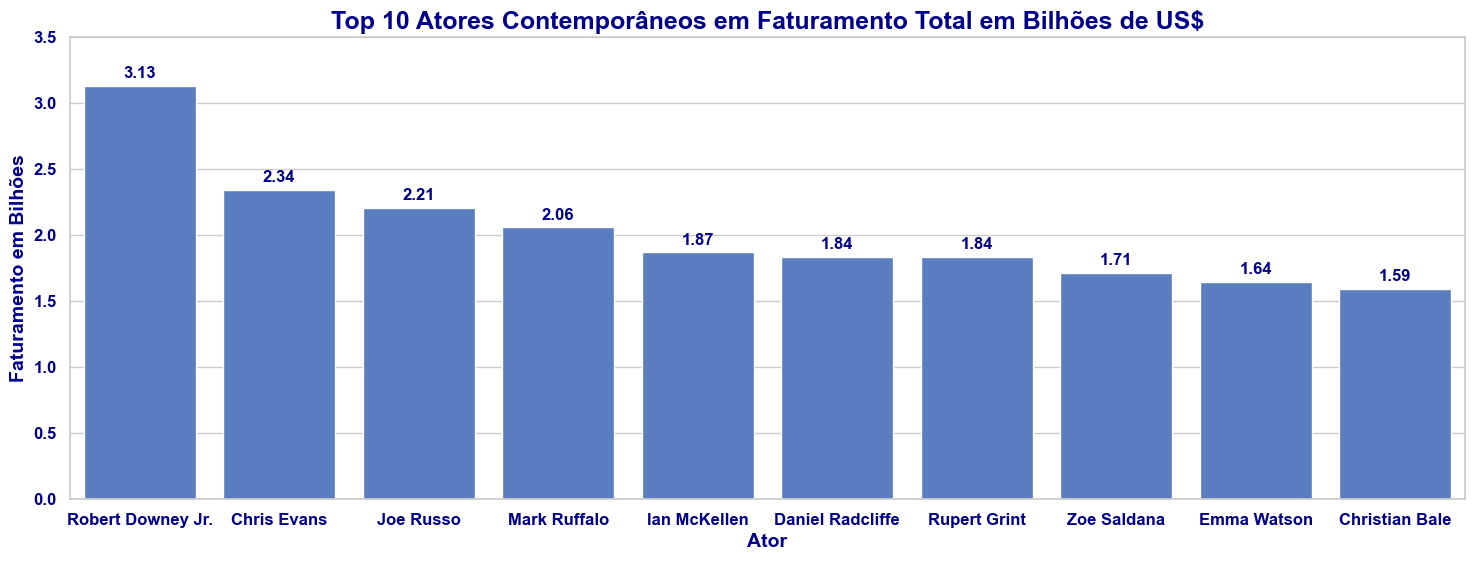

In [52]:
# Obtendo o faturamento total de filmes por ator contemporâneo
df_groupby = actors_df.query('Year_Tag == "5 - Contemporary"')\
                      .groupby("Actor").agg(faturamento_soma = ("Gross", "sum"))\
                      .sort_values("faturamento_soma",ascending=False)\
                      .head(10)

# Convertendo o resultado para bilhões para facilitar a plotagem.
df_groupby["faturamento_soma"] = df_groupby["faturamento_soma"] / 10**9

barplot_custom(df_groupby,
               figsize=(18,6),
               col_x= 'Actor',
               col_y = 'faturamento_soma',
               title= "Top 10 Atores Contemporâneos em Faturamento Total em Bilhões de US$",
               y_label='Faturamento em Bilhões',
               x_label = 'Ator',
               bar_anotate=True,
               anotate_float=2,
               y_lim=[0,3.5])

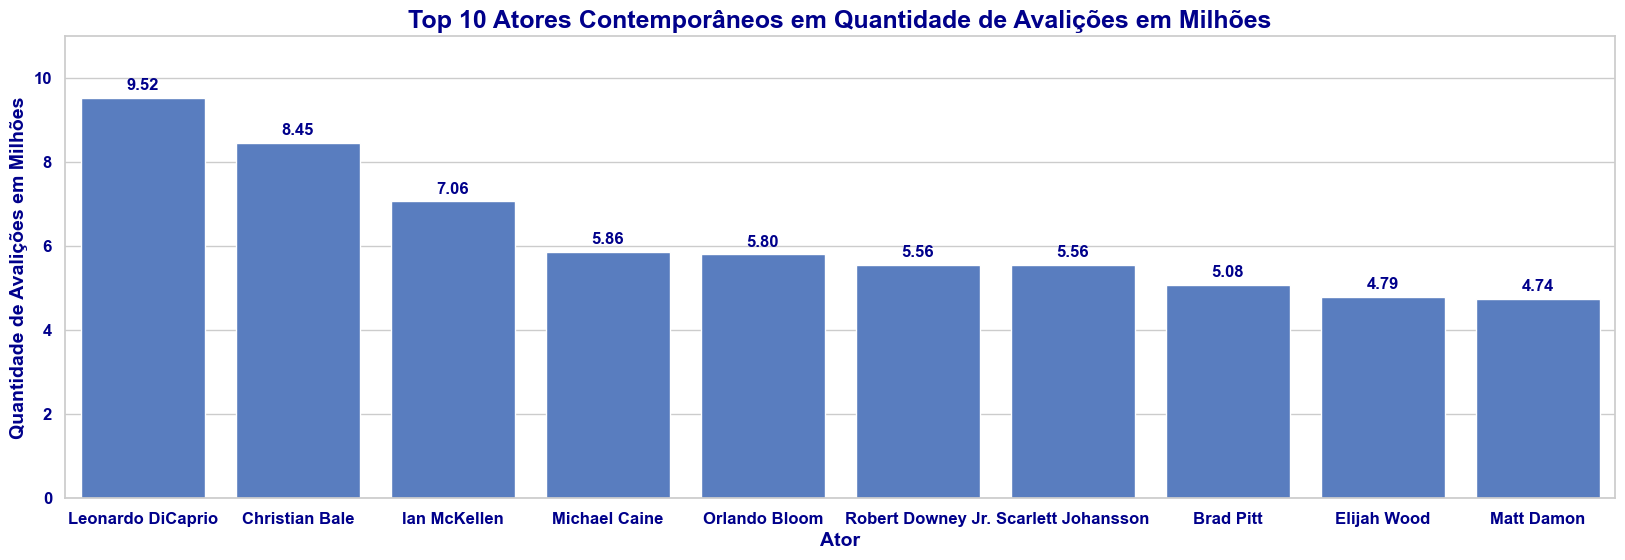

In [53]:
# Obtendo a quantidade de votos total de filmes por ator contemporâneo
df_groupby = actors_df.query('Year_Tag == "5 - Contemporary"')\
                      .groupby("Actor").agg(qtd_avaliacoes = ("No_of_Votes", "sum"))\
                      .sort_values("qtd_avaliacoes",ascending=False)\
                      .head(10)

# Convertendo o resultado para milhões para facilitar a plotagem.
df_groupby["qtd_avaliacoes"] = df_groupby["qtd_avaliacoes"] / 10**6

barplot_custom(df_groupby,
               figsize=(20,6),
               col_x = 'Actor',
               col_y = 'qtd_avaliacoes',
               title = "Top 10 Atores Contemporâneos em Quantidade de Avalições em Milhões",
               y_label ='Quantidade de Avalições em Milhões',
               x_label = 'Ator',
               bar_anotate = True,
               anotate_float = 2,
               y_lim=[0,11])

- Nota-se que a quantidade de avaliações de um filme, considerando-se o elenco pode não implicar em um alto faturamento, visto que o ator Leonardo DiCaprio, que esta presente nos filmes mais avaliados, não está presente no top 10 atores com maior arrecadação em filmes.

### Distribuições e Correlação

Ao utilizar o método `describe()` é possivel verificar que as colunas `No_of_Votes` e  `Gross` podem conter outliers, pois os valores máximos e mínimos são discrepantes dos 75% destes dados.

In [54]:
# Resumo estatístico
df.drop("Released_Year", axis = 1).describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.00,999.00,842.00,999.00,830.00
mean,122.87,7.95,77.97,271621.42,68082574.10
std,28.10,0.27,12.38,320912.62,109807553.39
min,45.00,7.60,28.00,25088.00,1305.00
25%,103.00,7.70,70.00,55471.50,3245338.50
50%,119.00,7.90,79.00,138356.00,23457439.50
75%,137.00,8.10,87.00,373167.50,80876340.25
max,321.00,9.20,100.00,2303232.00,936662225.00


In [122]:
# Resumo estatístico para filmes contemporâneos
df.query('Year_Tag == "5 - Contemporary"').drop("Released_Year", axis = 1).describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,485.00,485.00,418.00,485.00,430.00
mean,125.72,7.91,75.54,327808.90,86689221.00
std,24.98,0.26,12.04,334735.24,131340074.26
min,71.00,7.60,28.00,25198.00,1305.00
25%,108.00,7.70,69.00,66803.00,3042292.00
50%,122.00,7.90,77.00,213970.00,27122954.50
75%,139.00,8.10,84.00,492851.00,124958354.75
max,321.00,9.00,100.00,2303232.00,936662225.00


- Os filmes possuem uma duração média de 122 minutos, o filme com a menor duração possui 45 minutos, já o filme mais longo possui 321 minutos de duração, no conjunto de dados 75% dos filmes possuem uma duração igual ou menor a 137 minutos, refletindo uma dispersão considerável devido à diferença entre o valor mínimo e máximo. O desvio padrão de 28,10 minutos indica uma variabilidade significativa na duração dos filmes.

- Os filmes apresentam uma avaliação média no IMDB de 7.95, com um desvio padrão baixo de 0.27. A avaliação varia de 7.6 a 9.2, observa-se que 75% dos filmes têm uma avaliação média de pelo menos 8.10, indicando que a maioria dos filmes no conjunto de dados possui uma recepção positiva.

- As avaliações do Meta Score exibem uma variação maior em relação ao IMDB, com um desvio padrão de 12.38. Os valores variam de 28 a 100, com uma média de 77.97. Observa-se que 75% dos filmes possuem uma avaliação de pelo menos 87, é uma tendência geral alta e relativamente semelhante as avaliações do IMDB.

- A quantidade de votos minima é 25088 e máxima de 2303232, o que se destaca é a variancia do desvio padrão de 271621,42, indicando que os dados estão dispersos com alguns filmes recebendo um número muito alto de votos, enquanto outros têm uma quantidade significativamente menor. A média de avaliações por filme é de cerca de 271 mil avaliações.

- O faturamento dos filmes tem um mínimo de US$1.305,00 e um máximo de US$936.662.225,00. A média é de US$68.082.574,10 e o desvio padrão atinge US$109.807.553,39. Os 75% dos filmes têm um faturamento de pelo menos US$ 80.876.340,25

**Filmes contemporâneos**

Fazendo a mesma análise selecionando somente os filmes contenporâneios, vemos que médias das avaliações decaem, porem o faturamento médio e quantidade de avaliações médias aumentam aumentam significativamente, mostrando-se que o cinema está mais popular e com maior receita.

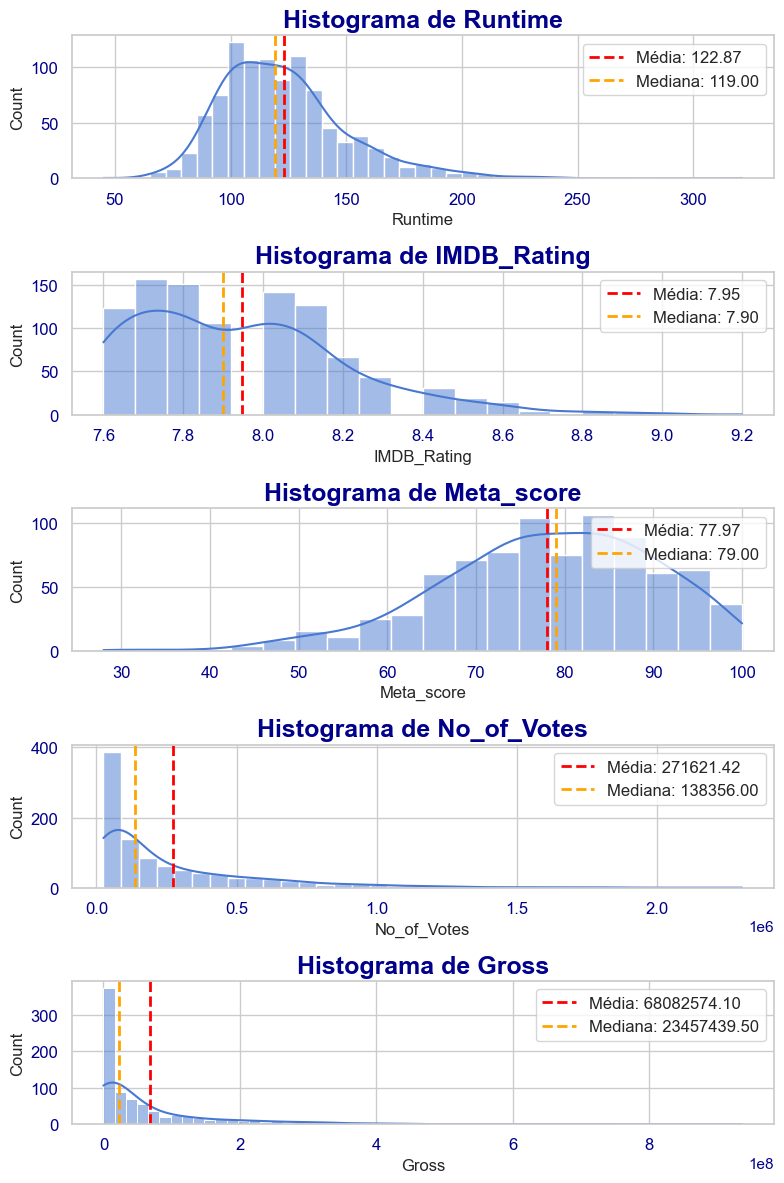

In [155]:
# Plotando subplots de histogramas das variáveis númericas
columns_numeric = ["Runtime",'IMDB_Rating', "Meta_score","No_of_Votes","Gross" ]
fig, axes = plt.subplots(len(columns_numeric), 1, figsize=(8, 12))

for ax, col in zip(axes, columns_numeric):
    #plotando o histograma para cada variavel númerica
    sns.histplot(data = df[col], ax=ax, kde=True)

    # Definindo o título
    ax.set_title(f'Histograma de {col}',fontsize=18, weight='bold', color='darkblue')
    #Customizando as marcações dos gráficos eixos x e y
    ax.tick_params(axis='x', labelsize=12,  colors='darkblue')
    ax.tick_params(axis='y', labelsize=12, colors='darkblue')

    # Adicionando a linha vermelha da média
    mean_value = df[col].mean()
    mean_line = ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    
    # Adicionando a linha laranja da mediana
    median_value = df[col].median()
    median_line = ax.axvline(median_value, color='orange', linestyle='dashed', linewidth=2, label=f'Mediana: {median_value:.2f}')

    # incluindo a legenda
    ax.legend([mean_line, median_line], [f'Média: {mean_value:.2f}', f'Mediana: {median_value:.2f}'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

Analisando os histogramas, nota-se que as distribuições das variáveis são assimétricas. Indica que os dados não seguem uma distribuição normal e podem outliers.

- Runtime: A maioria dos filmes tem uma duração concentrada em torno de 120 minutos com média e mediana próximos, com alguns outliers significativamente mais longos, refletindo uma distribuição assimétrica.
- IMDB_Rating: As avaliações no IMDB são fortemente concentradas em torno de valores altos, nenhuma avaliação baixa, representando uma distribuição levemente enviesada à esquerda.
- Meta_score: Similar ao IMDB, as avaliações do Meta Score mostram uma concentração em valores altos, porem com valores baixos presentes aumentando a variabilidade, indicando uma assimetria.
- No_of_Votes: A quantidade de votos apresenta uma assimetria à direita, com a maioria dos filmes recebendo um número relativamente baixo de votos e poucos filmes recebendo votos excepcionalmente altos.
- Gross: O faturamento dos filmes também é assimétrico à direita, com a maioria dos filmes tendo receitas modestas enquanto alguns poucos filmes têm receitas extremamente altas.


Essas características assimétricas impactam na aplicação de modelos estatísticos ou de machine learning, Assim sendo, é necessário um trabalho de transformações dos dados quee podem melhorar a qualidade dos modelos.

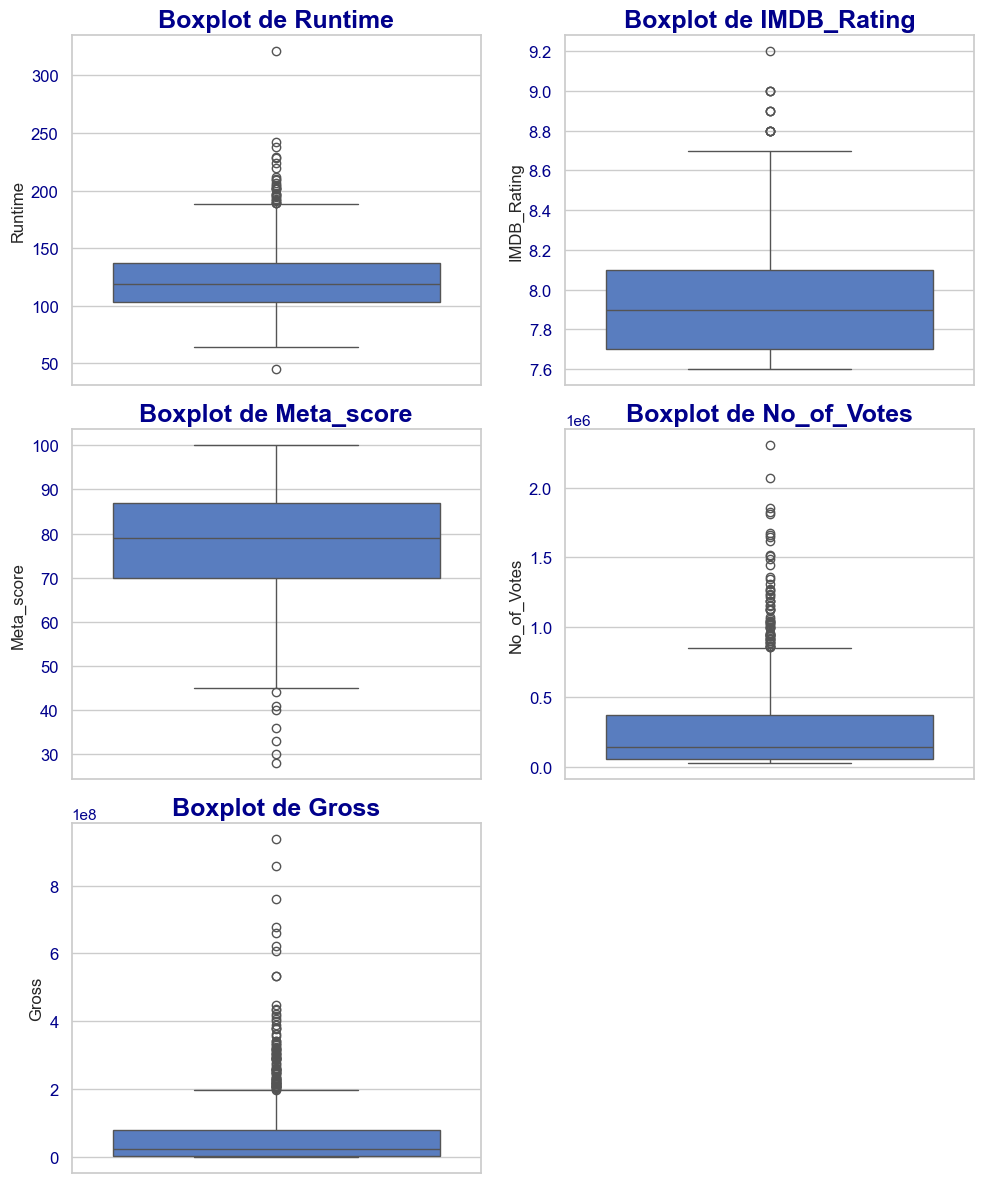

In [166]:
# Cria subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
# Achatando a matriz de eixos para para a dimensão necessária dos axes do subplots
axes = axes.flatten()

# Plotando um gráfico de boxplot cada coluna em um subplot diferente
for ax, col in zip(axes, columns_numeric):
    sns.boxplot(data = df[col], ax=ax)

    # customizando o título
    ax.set_title(f'Boxplot de {col}',fontsize=18, weight='bold', color='darkblue')
    #Customizando as marcações dos gráficos eixos x e y
    ax.tick_params(axis='x', labelsize=12,  colors='darkblue')
    ax.tick_params(axis='y', labelsize=12, colors='darkblue')


# Remove os subplots extras que não contêm gráficos
for i in range(len(columns_numeric), len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout
plt.tight_layout()
plt.show()

Com os gráficos de Boxplot também confirmamos a presença de valores outliers em todos os dados númericos.

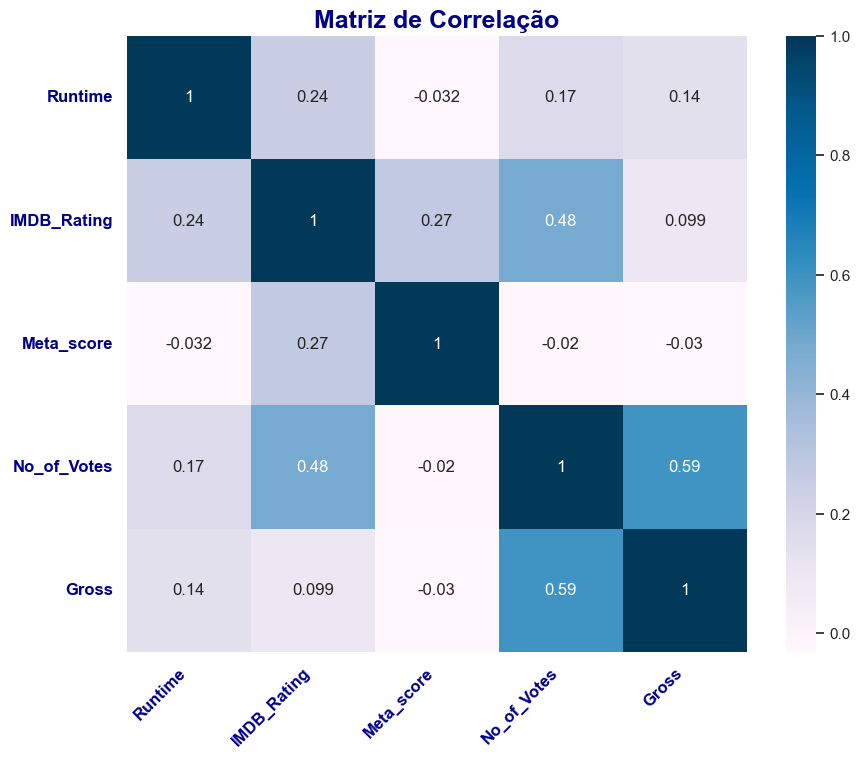

In [175]:
# Plotando o gráfico de correlação
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df[columns_numeric].corr(), annot=True, cmap = "PuBu")

# Customizando o gráfico 
ax.set_title('Matriz de Correlação',fontsize=18, weight='bold', color='darkblue')
plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold', color='darkblue')
plt.yticks(rotation=0, fontsize=12, weight='bold', color='darkblue')
plt.show()

- Com a matriz de correlação utilizando como coeficiente a correlação de pearson, denotamos que as variáveis que mais possuem correlação linear positiva são as variáveis respectivas à quantidade de votos pela variável faturamento dos filmes.
- Considerando o rating do IMDB, a variável que maior correlação positiva é também o numero de votos.

Embora não possamos inferir causalidade a partir da correlação, podemos considerar algumas relações lógicas observadas nos dados. Por exemplo:

**Popularidade e Arrecadação:** É possivel supor que filmes mais populares tendem a ter uma arrecadação maior. A popularidade de um filme, medida pelo número de votos ou avaliações, reflete seu alcance e aceitação pelo público. Filmes que atraem um grande público provavelmente geram maior receita de bilheteria, merchandising e outras fontes de renda.

**Avaliação e Popularidade:** Da mesma forma, filmes com avaliações mais altas tendem a ser mais populares. Avaliações positivas no IMDB ou em outros agregadores de crítica podem impulsionar o interesse do público, resultando em um maior número de votos e, consequentemente, maior popularidade.

# 3. Preparação dos Dados

Neste passo, é definida a abordagem de limpeza, enriquecimento de dados e separação em conjuntos de dados treino e teste.

Os tratamentos e transformações de dados já foram efetuados previamente para as analises anteriores, ficando pendente somente a limpeza/correção de dados nulos.

A abordagem que efeturei de remoção, julgo como a "incorreta", visto que desta forma você pode perder informações valiosas, porem como os dados númericos também não seguem uma distribuição normal, não imputarei valores como médias pois podem ser muito distantes das informações reais, em uma abordagem real, utilizaria as médias agrupadas pelas variáveis categóricas, existem bibliotecas de limpezas de dados como, por exemplo, [PyJanitor](https://pyjanitor-devs.github.io/pyjanitor/) que possuem métodos para este tipo de correção.

In [388]:
#Remoção de dados nulos
df_copia = df.dropna().reset_index(drop=True).copy()


A segunda etapa seria a seleção de Features e nossa variável target para treino e teste do modelo.


**Dados Selecionados**
| Variável     | Tipo       | Transformação Necessária                     |
|--------------|------------|----------------------------------------------|
| Certificate  | Categórica | One-hot encoding                             |
| Genre        | Categórica | One-hot encoding                             |
| Runtime      | Numérica   | Normalização ou Padronização                 |
| Meta_score   | Numérica   | Normalização ou Padronização                 |
| No_of_Votes  | Numérica   | Normalização ou Padronização                 |
| Gross        | Numérica   | Transformação Logarítmica e Normalização     |
| Year_Tag     | Categórica | Conversão para variável dummy ou ordinal     |


**Dados Descartados**

| Variável      | Tipo       | Motivo para remoção                                           |
|---------------|------------|---------------------------------------------------------------|
| Series_Title  | Categórica | Apenas representa o título do filme, não fornece informação adicional para o modelo |
| Released_Year | Numérica   | Redundante, pois a variável Year_Tag já contém essa informação de maneira categorizada |
| Overview      | Categórica | É uma descrição textual extensa, difícil de ser utilizada diretamente no modelo |
| Director      | Categórica | Pode introduzir alta cardinalidade e novos diretores podem não estar presentes nos dados de treino |
| Stars         | Categórica | Similar ao diretor, pode introduzir alta cardinalidade e novos atores podem não estar presentes nos dados de treino |


In [379]:
def transform_data(df):
    '''
    Aplica as transformações necessárias para treinamento do modelo
    '''

    # Listas de gêneros, certificados e tags de ano
    generos = ['Horror', 'Crime', 'Animation', 'Comedy',
               'Fantasy', 'Sport', 'Adventure', 'Biography',
               'Action', 'War', 'Sci-Fi', 'Thriller', 'Film-Noir',
               'History', 'Musical', 'Western', 'Family', 'Drama',
               'Music', 'Romance', 'Mystery']

    certificate = ['Approved', 'R', 'Passed', 'PG-13', 'U/A', 'U',
                   'TV-14', 'TV-PG', 'A', 'TV-MA', 'UA', 'G', '16',
                   'GP', 'Unrated', 'PG']

    year_tag = ['4 - Modern Era', '2 - Golden Era', '3 - New Wave',
                '5 - Contemporary', '1 - Early Cinema']

    # Criar cópia do DataFrame original sem valores nulos
    df_copia = df.dropna().reset_index(drop=True).copy()
    
    # Tratamento necessário nos dados
    df_copia['Gross'] = df_copia['Gross'].astype(str).str.replace(',', '').astype(float)
    df_copia['Runtime'] = df_copia['Runtime'].astype(str).str.replace(' min', '').astype(int)
    df_copia['Released_Year'] = df_copia['Released_Year'].astype(int)
    

    # Adicionar a variável Year_tag
    df_copia['Year_Tag'] = df_copia['Released_Year'].apply(get_release_year_tag)

    # Criar colunas para cada gênero, certificado e tag de ano
    for col in generos + certificate + year_tag:
        df_copia[col] = 0
    
    # Preencher as colunas de gênero
    for idx, row in df_copia.iterrows():
        for genre in row['Genre'].split(', '):
            df_copia.at[idx, genre] = 1

    # Preencher as colunas de certificado
    for idx, row in df_copia.iterrows():
        cert = row['Certificate']
        if cert in certificate:
            df_copia.at[idx, cert] = 1

    # Preencher as colunas de tag de ano
    for idx, row in df_copia.iterrows():
        year_tag_val = row['Year_Tag']
        if year_tag_val in year_tag:
            df_copia.at[idx, year_tag_val] = 1

    # Remover colunas originais de gênero, certificado e Year_Tag
    df_copia.drop(['Series_Title','Genre', 'Certificate', 
                   'Year_Tag','Director','Star1','Star2',
                   'Star3','Star4','Released_Year'], axis=1, inplace=True)

    return df_copia

In [393]:
# Aplico as transformações aos dade treino
X = transform_data(df_copia).drop(["IMDB_Rating", 'Overview'], axis = 1)

# Seleciono a variável target
y = df_copia['IMDB_Rating']


In [396]:
# Intancio StandardScaler para normalização dos dados
scaler = StandardScaler()
X[["Runtime", "Meta_score","No_of_Votes","Gross"]] = scaler.fit_transform(X[["Runtime", "Meta_score","No_of_Votes","Gross"]])

In [397]:
X.head()

,Runtime,Meta_score,No_of_Votes,Gross,Horror,Crime,Animation,Comedy,Fantasy,Sport,...,G,16,GP,Unrated,PG,4 - Modern Era,2 - Golden Era,3 - New Wave,5 - Contemporary,1 - Early Cinema
0,1.98,1.84,3.66,0.49,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.09,0.55,5.64,3.97,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3.03,1.04,2.24,-0.19,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-1.07,1.52,0.97,-0.65,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2.99,1.36,3.73,2.60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [398]:
# Dimensões dos dados após processamento
X.shape

(713, 46)

In [399]:
# Faço a separação em dados de treino e teste com 30% para dados de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [454]:
# Dimensões dos meus dados de treino
X_train.shape

(499, 46)

In [455]:
# Dimensões dos meus dados de deste
X_test.shape

(214, 46)

# 4. Modelagem

4.1 Teste de Múltiplos Modelos para Predição da Nota IMDB

**Regressão Linear**

In [526]:
model_lr = LinearRegression()

In [527]:
%%time
model_lr.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 3 ms


LinearRegression()

**Decision Tree Regressor**

In [528]:
model_dtr = DecisionTreeRegressor()

In [529]:
%%time
model_dtr.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 5 ms


DecisionTreeRegressor()

**GradientBoostingRegressor**

In [530]:
model_gbr = GradientBoostingRegressor()

In [531]:
%%time
model_gbr.fit(X_train, y_train)

CPU times: total: 109 ms
Wall time: 80 ms


GradientBoostingRegressor()

**Perceptron**

In [532]:
model_en = ElasticNet()

In [533]:
%%time
model_en.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 3 ms


ElasticNet()

### Fine Tuning melhor modelo

In [495]:
model_gbr_tunned = HyperoptEstimator(regressor=gradient_boosting_regressor('model_tunned'),
                          preprocessing=any_preprocessing("pre"),
                          algo=tpe.suggest,
                          max_evals=25,
                          trial_timeout=120)

In [496]:
model_gbr_tunned.fit(X_train, y_train)

100%|██████████| 25/25 [00:01<00:00,  1.37s/trial, best loss: 0.43539580771646147]


In [513]:
model_gbr_tunned.best_model()

{'learner': GradientBoostingRegressor(alpha=0.8511466451230976,
                           learning_rate=0.4621430487906937,
                           max_features=0.15489119313691646, min_samples_split=3,
                           n_estimators=173, random_state=1, verbose=False),
 'preprocs': (StandardScaler(with_std=False),),
 'ex_preprocs': ()}

In [514]:
model_gbr_v2 = model_gbr_tunned.best_model().get('learner')

In [534]:
%%time
model_gbr_v2.fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 64 ms


GradientBoostingRegressor(alpha=0.8511466451230976,
                          learning_rate=0.4621430487906937,
                          max_features=0.15489119313691646, min_samples_split=3,
                          n_estimators=173, random_state=1, verbose=False)

## 5. Avaliação

In [535]:
avaliacao_modelos = {}

**Regressão Linear**

In [536]:
y_pred_lr = model_lr.predict(X_test)

In [537]:
mae = metrics.mean_absolute_error(y_test, y_pred_lr)
avaliacao_modelos[str(model_lr.__class__.__name__)] = mae

**Decision Tree Regressor**

In [538]:
y_pred_dtr = model_dtr.predict(X_test)

In [539]:
mae = metrics.mean_absolute_error(y_test, y_pred_dtr)
avaliacao_modelos[str(model_dtr.__class__.__name__)] = mae

**Gradient Boosting Regressor**

In [540]:
y_pred_gbr = model_gbr.predict(X_test)

In [541]:
mae = metrics.mean_absolute_error(y_test, y_pred_gbr)
avaliacao_modelos[str(model_gbr.__class__.__name__)] = mae

**ElasticNet**

In [542]:
y_pred_en = model_en.predict(X_test)

In [543]:
mae = metrics.mean_absolute_error(y_test, y_pred_en)
avaliacao_modelos[str(model_en.__class__.__name__)] = mae

In [555]:
df_avaliacao = pd.DataFrame(avaliacao_modelos.items(), columns=['Modelo', 'MAE'])

**Gradient Boosting Regressor com Fine Tunning**

In [545]:
y_pred_gbr_v2 = model_gbr_v2.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred_gbr_v2)
avaliacao_modelos[str(model_gbr_v2.__class__.__name__)+'_v2'] = mae

In [550]:
avaliacao_modelos

{'LinearRegression': 0.15668573464597882,
 'DecisionTreeRegressor': 0.197196261682243,
 'GradientBoostingRegressor': 0.14883677180021662,
 'ElasticNet': 0.22331391755473562,
 'GradientBoostingRegressor_v2': 0.16588374005716652}

f_groupby, col_x, col_y, title, x_label = False, y_label = False, bar_anotate = False, y_lim = False, figsize = (12,8), anotate_float = False

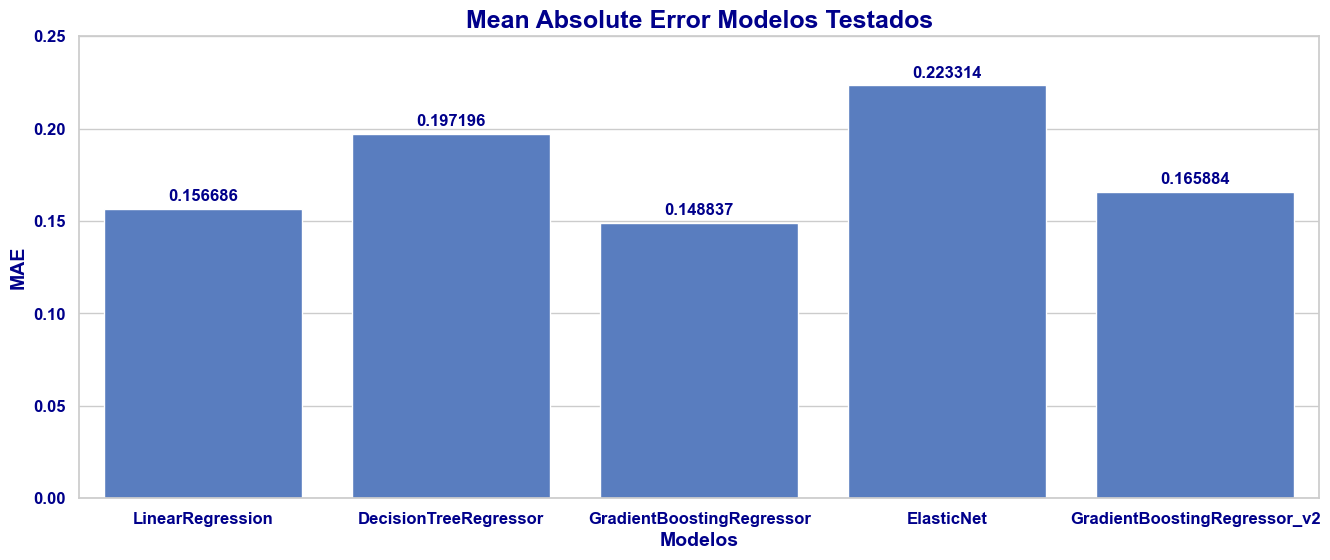

In [574]:
barplot_custom(df_avaliacao, 
               col_x="Modelo", 
               col_y="MAE", 
               title="Mean Absolute Error Modelos Testados", 
               bar_anotate = True, 
               anotate_float= 6, 
               figsize = (16,6),
               y_lim = [0,0.25],
               y_label = "MAE",
               x_label="Modelos"
               )

## 6. Deploy

# Perguntas do Desafio

### 1 - Qual filme você recomendaria para uma pessoa que você não conhece?

Para definir qual filme indicar de forma somente explortória, irei considerar a quantidade de avaliações dos filmes contemporâneos em relação a atores, direção e genero mais populares.

- O ator **Leonardo DiCaprio**  é o mais popular, somando 9521072 de votos em seus filmes contemporâneos.
- O diretor mais popular da atualidade considerando-se a quantidade total de avaliações é o **Christopher Nolan** 
- Os 3 generos mais popular são **Drama**, **Ação** e **Aventura** em quantidade total de avaliações.

In [74]:
ator = 'Actor == "Leonardo DiCaprio"'
diretor = 'Director == "Christopher Nolan"'
genero = '(Genre.str.contains("Drama") | Genre.str.contains("Action") | Genre.str.contains("Adventure"))'

actors_df.query(f'''{ator} & {diretor} & {genero}''')

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Year_Tag,Star,Actor
7,Inception,2010,UA,148,"Action, Adventure, Sci-Fi",8.80,A thief who steals corporate secrets through t...,74.00,Christopher Nolan,2067042,292576195.00,5 - Contemporary,Star1,Leonardo DiCaprio


### 2 - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

O faturamento do filme tem maior correção positiva com a quantidade votos.

In [75]:
df[columns_numeric].corr().style

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
Runtime,1.000000,0.242751,-0.031604,0.172483,0.140002
IMDB_Rating,0.242751,1.000000,0.271374,0.479308,0.099393
Meta_score,-0.031604,0.271374,1.000000,-0.020091,-0.030480
No_of_Votes,0.172483,0.479308,-0.020091,1.000000,0.589527
Gross,0.140002,0.099393,-0.030480,0.589527,1.000000


**Teste de Esfericidade de Bartlett**

A hipótese nula é que as variáveis não são correlacionadas.

[Documentação](https://factor-analyzer.readthedocs.io/en/latest/index.html)

In [76]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns_numeric].dropna())

In [77]:
chi_square, p_valor = calculate_bartlett_sphericity(df_scaled)
print(f"A estatística do teste é {chi_square} e seu respectivo p-valor é {p_valor}")

A estatística do teste é 882.265714725565 e seu respectivo p-valor é 4.172992011482442e-183


Como o p valor é menor que 0.05 podemos rejeitar a hipótese nula, isto é, podemos considerar que há correlação entre todas as variáveis numéricas.

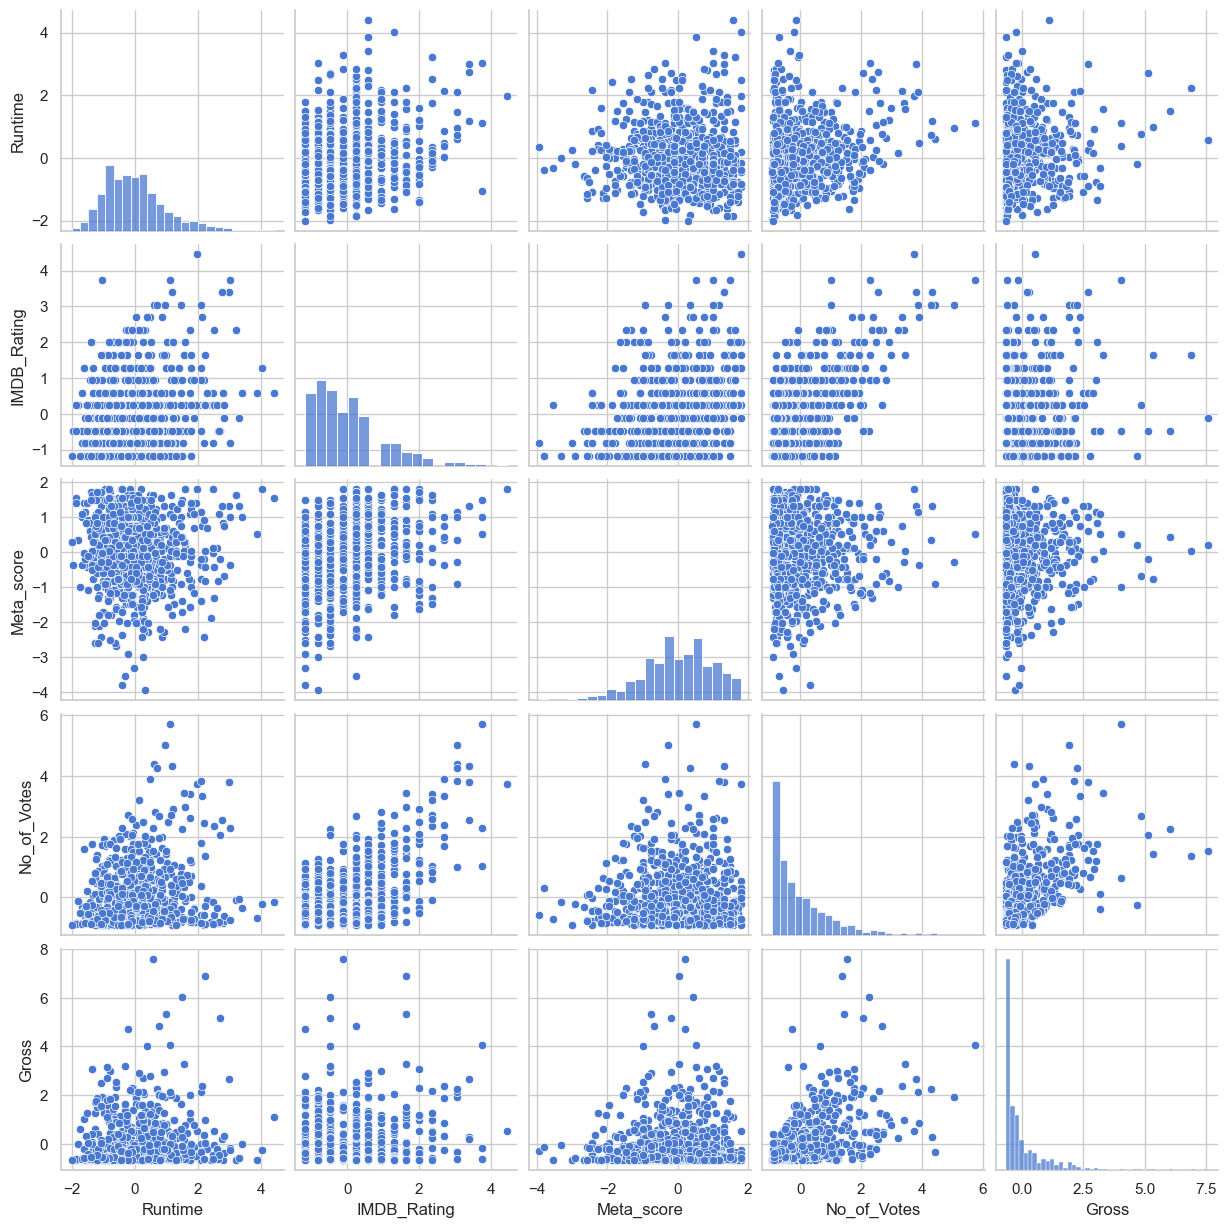

In [78]:
ax = sns.pairplot(df_scaled)

**Filmes Mais Rentaveis**

- Comparando-se os 10 filmes mais rentaveis, nota-se que quase todos possuem o gênero ação e classificação etária UA.

- Não podemos utilizar métricas estátisticas de correlação entre as variáveis categóricas e continuas.
- O ator que participou mais vezes dos filmes mais rentáveis é o **Robert Downey Jr**

In [79]:
df.sort_values("Gross",ascending=False).head(10)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Year_Tag
476,Star Wars: Episode VII - The Force Awakens,2015,U,138,"Action, Adventure, Sci-Fi",7.90,"As a new threat to the galaxy rises, Rey, a de...",80.00,J.J. Abrams,Daisy Ridley,John Boyega,Oscar Isaac,Domhnall Gleeson,860823,936662225.00,5 - Contemporary
58,Avengers: Endgame,2019,UA,181,"Action, Adventure, Drama",8.40,After the devastating events of Avengers: Infi...,78.00,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Evans,Mark Ruffalo,809955,858373000.00,5 - Contemporary
622,Avatar,2009,UA,162,"Action, Adventure, Fantasy",7.80,A paraplegic Marine dispatched to the moon Pan...,83.00,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,Michelle Rodriguez,1118998,760507625.00,5 - Contemporary
59,Avengers: Infinity War,2018,UA,149,"Action, Adventure, Sci-Fi",8.40,The Avengers and their allies must be willing ...,68.00,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,834477,678815482.00,5 - Contemporary
651,Titanic,1997,UA,194,"Drama, Romance",7.80,A seventeen-year-old aristocrat falls in love ...,75.00,James Cameron,Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,1046089,659325379.00,4 - Modern Era
356,The Avengers,2012,UA,143,"Action, Adventure, Sci-Fi",8.00,Earth's mightiest heroes must come together an...,69.00,Joss Whedon,Robert Downey Jr.,Chris Evans,Scarlett Johansson,Jeremy Renner,1260806,623279547.00,5 - Contemporary
890,Incredibles 2,2018,UA,118,"Animation, Action, Adventure",7.60,The Incredibles family takes on a new mission ...,80.00,Brad Bird,Craig T. Nelson,Holly Hunter,Sarah Vowell,Huck Milner,250057,608581744.00,5 - Contemporary
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.00,5 - Contemporary
581,Rogue One,2016,UA,133,"Action, Adventure, Sci-Fi",7.80,The daughter of an Imperial scientist joins th...,65.00,Gareth Edwards,Felicity Jones,Diego Luna,Alan Tudyk,Donnie Yen,556608,532177324.00,5 - Contemporary
62,The Dark Knight Rises,2012,UA,164,"Action, Adventure",8.40,Eight years after the Joker's reign of anarchy...,78.00,Christopher Nolan,Christian Bale,Tom Hardy,Anne Hathaway,Gary Oldman,1516346,448139099.00,5 - Contemporary


**Analisando os 75% Mais Rentaveis**

In [80]:
df_q1_generos = generos[generos['Gross'] > generos.Gross.quantile(0.75)]\
                        .sort_values("Gross", ascending=False)\
                        .reset_index(drop=True)

In [81]:
df_q1_generos.groupby("Genre").agg(media_faturamento=('Gross','mean'),
                                   soma_faturamento=('Gross','sum'))\
            .style.highlight_max(color='green')

,media_faturamento,soma_faturamento
Genre,,
Action,282420682.842857,19769447799.000000
Adventure,286253613.879121,26049078863.000000
Animation,260356251.290323,8071043790.000000
Biography,139430068.857143,2928031446.000000
Comedy,230289175.950000,9211567038.000000
Crime,164772072.954545,3624985605.000000
Drama,175892626.227723,17765155249.000000
Family,225011286.125000,3600180578.000000
Fantasy,263618348.200000,5272366964.000000


In [82]:
df_q1_actors = actors_df[actors_df['Gross'] > actors_df.Gross.quantile(0.75)]\
                        .sort_values("Gross", ascending=False)\
                        .reset_index(drop=True)


In [83]:
df_q1_actors.groupby("Actor").agg(media_faturamento=('Gross','mean'),
                                  soma_faturamento=('Gross','sum'))\
            .sort_values('soma_faturamento',ascending=False)\
            .head(30)\
            .style.highlight_max(color='green')

,media_faturamento,soma_faturamento
Actor,,
Robert Downey Jr.,515998859.666667,3095993158.000000
Tom Hanks,229493900.666667,2753926808.000000
Chris Evans,462972643.800000,2314863219.000000
Joe Russo,551259850.750000,2205039403.000000
Leonardo DiCaprio,220306769.333333,1982760924.000000
Mark Ruffalo,495064926.250000,1980259705.000000
Daniel Radcliffe,305983505.666667,1835901034.000000
Rupert Grint,305983505.666667,1835901034.000000
Ian McKellen,305205662.833333,1831233977.000000


Considerando a análise dos filmes classicados no q1 (+75%), se no elenco possuir o ator **Robert Downey Jr.** e o filme possuir os gêneros **Sci-Fi** e **Aventura**, o filme será rentavel.

### 3 - Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Sim, é possivel utilizar um modelo de classificação e predizer a partir de um texto de Overview o seu gênero.

**Modelo de Classificação de Texto**

Efetuei o finetuning do modelo distilbert pretreinado que está disponível no **Hugging Face**, não consegui uma acuracia boa o sulficiente, em 3 epocas de treino que duraram certa de 40~ minutos, mesmo utilizando uma GPU GTX 1080 como device, atingi somente a acuracia: 0.2815, descartei o modelo do notebook pois certamente um DummieClassifier teria uma acuracia melhor,alem do que pode dificultar as execuções futuras do notebook, porem é perfeitamente possivel efetuar uma classificação multiclasse e predizer a classe do filme utilizando somente a variável overview.

Pontos importantes para efetuar esta execução, é mais prático utilizar um modelo pré treinado, pois assim é necessário utilizar menos tempo na experimentação, visto que construir uma arquitetura de deep learning para NLP do zero, é necessário definir cada camada da rede, além de ter o conhecimento razoável sobre arquiteturas complexas, otimizadores, funções de ativaçães e afins.

Na minha abordagem percebi que é necessário dedicar-se mais tempo ao tratamento dos dados, devido as classes serem desbalanceadas é necessário usar algum método de enriquecimento de dados para o balanceamento das classes para evitar o overfitting, de todo modo, o link do modelo que fiz o finetunning esta no [huggingface](https://huggingface.co/Aurelio-Guilherme/Model) onde pode ser trabalhado futuramente.

Outra forma de abordar este problema seria localizar as palavras mais comuns por gênero, e efetuar uma classficação menos robuscada, possivelmente teria uma acurácia superior ao modelo que experimentei.



### 4 - Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

### 5 - Supondo um filme com as seguintes características:

```
{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}
 ```

### Qual seria a nota do IMDB?

In [576]:
novos_dados = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

df_novos = pd.DataFrame([novos_dados])

In [577]:
X_novos = transform_data(df_novos)

In [578]:
X_novos[["Runtime", "Meta_score","No_of_Votes","Gross"]] = scaler.transform(X_novos[["Runtime", "Meta_score","No_of_Votes","Gross"]])

In [583]:
model_gbr.predict(X_novos)

array([8.79453705])

- O modelo que melhor performou predice que a avaliação do IMDB seria de 8.79

### 6 - Salve o modelo desenvolvido no formato .pkl. 

In [586]:
outdir = 'model'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [590]:
pickle.dump(model_gbr, open(f'{outdir}/{model_gbr.__class__.__name__}-model.pkl', 'wb'))

## Desafio
Você foi alocado em um time da Indicium contratado por um estúdio de Hollywood chamado PProductions, e agora deve fazer uma análise em cima de um banco de dados cinematográfico para orientar qual tipo de filme deve ser o próximo a ser desenvolvido. Lembre-se que há muito dinheiro envolvido, então a análise deve ser muito detalhada e levar em consideração o máximo de fatores possíveis (a introdução de dados externos é permitida - e encorajada).


**A entrega deve ser feita através de um repositório de código público que contenha:**
- README explicando como instalar e executar o projeto
- Arquivo de requisitos com todos os pacotes utilizados e suas versões
- Relatórios das análises estatísticas e EDA em PDF, Jupyter Notebook ou semelhante conforme passo 1 e 2.
- Códigos de modelagem utilizados no passo 3 (pode ser entregue no mesmo Jupyter Notebook).
- Arquivo .pkl conforme passo 5 acima.
- Todos os códigos produzidos devem seguir as boas práticas de codificação.

